In [1]:
%cd ../

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet


In [2]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from scipy.cluster.vq import vq, kmeans2
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingEN
from sklearn import metrics

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import ExpertNet,  target_distribution, source_distribution, CNN_AE, DAE, CNN_Classifier
from utils import *

In [3]:
# Dataset parameters
params = {
    'dir' : 'synthetic',
    'dataset' : 'cic',
    'input_dim': '-1',
    'n_features': '-1',
    'target': -1,
    'data_ratio': 1,

    # Training parameters
    'lr' : 0.002,
    'alpha' : 1,
    'wd' : 5e-4,
    'batch_size' : 512,
    'n_epochs' : 100,
    'n_runs' : 1,
    'pre_epoch' : 40,
    'pretrain' : True,
    "load_ae": False,
    "classifier": "LR",
    "tol": 0.01,
    "attention": 11,
    "ablation": 'None',
    "cluster_balance": 'hellinger',
    "verbose": 'True',

    # Model parameters
    'lamda' : 1,
    'beta' : 2, # KL loss/KM loss weight
    'gamma' : 1.5, # Classification loss weight
    'delta' : 1, # Class Balance weight
    'eta' : 0.0, # Class separation weight
    'hidden_dims' : [64, 32],
    'n_z' : 20,
    'n_clusters' : 3,
    'clustering' : 'cac',
    'n_classes'  : 2,
    'optimize': 'auprc',
    'lr_enc': 0.002,
    'lr_exp': 0.002,
    'ae_type': 'dae',
    'n_channels': 1,

    # Utility parameters
    'n_jobs' : 6,
    'device' : 'cpu',
    'plot': 'False',
    'expt': 'ExpertNet',
    'log_interval' : 2,
    'other' : 'False',
    'cluster_balance' : 'hellinger',
    'cluster_analysis' : 'False',
    'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model'
}

class parameters(object):
    def __init__(self, parser):
        self.input_dim = -1
        self.dataset = parser['dataset']
        if parser['n_features'] == -1:
            self.n_features = parser['input_dim']
        else:
            self.input_dim = parser['n_features']
            self.n_features = parser['n_features']
        
        self.target = parser['target']
        self.data_ratio = parser['data_ratio']

        # Training parameters
        self.lr_enc = parser['lr_enc']
        self.lr_exp = parser['lr_exp']
        self.alpha = float(parser['alpha'])
        self.wd = parser['wd']
        self.batch_size = parser['batch_size']
        self.n_epochs = parser['n_epochs']
        self.n_runs = parser['n_runs']
        self.pre_epoch = parser['pre_epoch']
        self.pretrain = parser['pretrain']
        self.load_ae = parser['load_ae']
        self.classifier = parser['classifier']
        self.tol = parser['tol']
        self.attention = parser['attention']
        self.ablation = parser['ablation']
        self.cluster_balance = parser['cluster_balance']

        # Model parameters
        self.lamda = parser['lamda']
        self.beta = parser['beta']
        self.gamma = parser['gamma']
        self.delta = parser['delta']
        self.eta = parser['eta']
        self.hidden_dims = parser['hidden_dims']
        self.latent_dim = self.n_z = parser['n_z']
        self.n_clusters = parser['n_clusters']
        self.clustering = parser['clustering']
        self.n_classes = parser['n_classes']
        self.optimize = parser['optimize']
        self.ae_type = parser['ae_type']
        self.n_channels = parser['n_channels']

        # Utility parameters
        self.device = parser['device']
        self.verbose = parser['verbose']
        self.plot = parser['plot']
        self.expt = parser['expt']
        self.cluster_analysis = parser['cluster_analysis']
        self.log_interval = parser['log_interval']
        self.pretrain_path = parser['pretrain_path']

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']
DATASETS = ['diabetes', 'ards', 'ards_new', 'cic', 'cic_new', 'sepsis', 'aki', 'aki_new', 'infant', 'wid_mortality',\
            'synthetic', 'titanic', 'magic', 'adult', 'creditcard', 'heart', 'cic_los', 'paper_synthetic']

DATA_DIR = "/Users/shivin/Document/NUS/Research/Data"
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/ExpertNet"


In [4]:
def initialization(args):
    base_suffix = ""

    for key in ['n_clusters', 'alpha', 'beta', 'gamma', 'delta', 'eta', 'attention']:
        print(key, args.__dict__[key])

    base_suffix += args.dataset
    base_suffix += "_" + args.ae_type
    base_suffix += "_k_" + str(args.n_clusters)
    base_suffix += "_att_" + str(args.attention)
    base_suffix += "_dr_" + str(args.data_ratio)

    base_suffix += str(args.target) + "_"
    base_suffix += str(args.n_clusters) + "_"
    base_suffix += str(args.attention) + "_"

    args.pretrain_path += "/" + args.dataset
    args.pretrain_path += "_" + args.ae_type
    args.pretrain_path += "_feats_" + str(args.n_features)
    args.pretrain_path += "_dr_" + str(args.data_ratio)
    args.pretrain_path += "_target_" + str(args.target) + ".pth"

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Initialiation ##################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    if args.ablation == "alpha":
        iter_array = alphas
        iteration_name = "Alpha"

    elif args.ablation == "beta":
        iter_array = betas
        iteration_name = "Beta"

    elif args.ablation == "gamma":
        iter_array = gammas
        iteration_name = "Gamma"

    elif args.ablation == "delta":
        iter_array = deltas
        iteration_name = "Delta"

    elif args.ablation == "k":
        iter_array = ks
        iteration_name = "K"

    else:
        iter_array = range(args.n_runs)
        iteration_name = "Run"

    return base_suffix, iter_array, iteration_name

In [5]:
args = parameters(params)
scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=0)
X_train_orig, y_train_orig = train_data
X_val_orig, y_val_orig = val_data
X_test_orig, y_test_orig = test_data

In [6]:
def extract_column(X, y, args):
    # to predict on some other variable
    col_idx = args.target
    n_classes = args.n_classes
    if col_idx == -1:
        return X, y
    # Create categorical variable of the col_idx'th column
    los_quantiles = np.quantile(X[:,col_idx], np.arange(n_classes+1)/n_classes)
    y_new = []
    for i in range(len(X)):
        lbl = int(X[i,col_idx]/n_classes)
        for j in range(n_classes):
            if los_quantiles[j] <= X[i,col_idx] <= los_quantiles[j+1]:
                lbl = j
        y_new.append(lbl)

    X_new = np.delete(X, col_idx, 1) # delete col_idx column
    y_new = np.array(y_new)
    return X_new, y_new

def get_attention(args):
    if args.attention == 0:
        attention_train = 0
        attention_test = 1

    elif args.attention == 1:
        attention_train = 0
        attention_test = 1

    elif args.attention == 10:
        attention_train = 1
        attention_test = 0

    elif args.attention == 11:
        attention_train = 1
        attention_test = 1
    return (attention_train, attention_test)

In [7]:
def test_expertnet(args, model, es, X_test, y_test, criterion):
    print("\n####################################################################################\n")
    print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)
    
    attention_train, attention_test = get_attention(args)
    
    # Load best model trained from local training phase
    model = es.load_checkpoint(model)

    model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    # Evaluate model on Test dataset
    q_test, z_test = model.encoder_forward(torch.FloatTensor(X_test).to(args.device), output="latent")
    cluster_ids = torch.argmax(q_test, axis=1)

    X_latents_data_loader = list(zip(z_test.to(args.device), q_test, y_test))

    test_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
        batch_size=1024, shuffle=False)


    test_loss = 0
    e_test_loss = 0
    local_sum_loss = 0

    test_preds_e = model.predict(torch.FloatTensor(X_test).to(args.device), attention=attention_test)
    e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
    test_metrics = performance_metrics(y_test, test_preds_e.detach().numpy(), args.n_classes)
    test_metrics['e_test_loss'] = e_test_loss
    print(test_metrics)
    return test_metrics

In [8]:
def local_training_expertnet(args, model, es, X_train, y_train, X_val, y_val, suffix, criterion):
    print("\n####################################################################################\n")
    print("Training Local Networks")
    
    attention_train, attention_test = get_attention(args)
    
    model = es.load_checkpoint(model)
    es = EarlyStoppingEN(dataset=suffix)

    q_train, z_train = model.encoder_forward(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
    cluster_id_train = torch.argmax(q_train, axis=1)

    X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

    train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
        batch_size=1024, shuffle=False)

    B = []

    print(np.bincount(cluster_id_train))
    # plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
         # torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

    # Post clustering training
    for local_epoch in range(args.n_epochs):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        acc = 0

        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        # Full training of local networks
        for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
            _, total_loss = model.expert_forward(None, y_batch, X_latents, q_batch, backprop_enc=False, backprop_local=True)

        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        # Evaluate model on Validation set
        q_val, z_val = model.encoder_forward(torch.FloatTensor(X_val).to(args.device), output="latent")
        cluster_ids_val = torch.argmax(q_val, axis=1)

        preds = model.predict(torch.FloatTensor(X_val).to(args.device))

        val_metrics = performance_metrics(y_val, preds.detach().numpy(), args.n_classes)
        val_f1  = val_metrics['f1_score']
        val_auc = val_metrics['auroc']
        val_auprc = val_metrics['auprc']
        val_minpse = val_metrics['minpse']

        val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')
        val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
        epoch_len = len(str(args.n_epochs))

        print_msg = (f'\n[{local_epoch:>{epoch_len}}/{args.n_epochs:>{epoch_len}}] ' +
                     f'valid_loss: {val_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' +
                     f'valid_AUPRC: {val_auprc:.3f} ' +
                     f'valid_MINPSE: {val_minpse:.3f} ' +
                     f'valid_Sil: {val_sil:.3f}')

        print(print_msg)

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        cluster_ids_train = torch.argmax(q_train, axis=1)

        if args.optimize == 'auc':
            opt = val_auc
        elif args.optimize == 'auprc':
            opt = val_auprc
        else:
            opt = -val_loss
        es([val_f1, opt], model)

        if es.early_stop == True or local_epoch == args.n_epochs - 1:
            # train_losses.append(train_loss.item())
            #sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
            #HTFD_scores.append(calculate_HTFD(X_train, cluster_ids_train))
            # wdfd_scores.append(calculate_WDFD(X_train, cluster_ids_train))
            break

    return model, es

In [9]:
def run_ExpertNet(args):
    base_suffix, iter_array, iteration_name = initialization(args)
    f1_scores, auc_scores, auprc_scores, acc_scores, minpse_scores = [], [], [], [], [] #Inattentive test results
    e_f1_scores, e_auc_scores, e_auprc_scores, e_acc_scores, e_minpse_scores = [], [], [], [], [] #Attentive test results
    sil_scores, wdfd_scores, HTFD_scores, w_HTFD_scores = [], [], [], []

    stu_f1_scores, stu_auc_scores, stu_auprc_scores, stu_acc_scores, stu_minpse_scores = [], [], [], [], [] #Attentive test results
    stu_sil_scores, stu_wdfd_scores, stu_HTFD_scores, stu_w_HTFD_scores = [], [], [], []

    # to track the training loss as the model trains
    test_losses, e_test_losses, local_sum_test_losses = [], [], []
    model_complexity = []
    attention_train, attention_test = get_attention(args)

    for r in range(len(iter_array)):
        scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=r, n_features=args.n_features)
        X_train, y_train = train_data
        X_val, y_val = val_data
        X_test, y_test = test_data

        X_train, y_train = extract_column(X_train, y_train, args)
        X_val, y_val = extract_column(X_val, y_val, args)
        X_test, y_test = extract_column(X_test, y_test, args)

        if args.target != -1:
            args.input_dim -= 1
            print("Predicting on column: ", column_names[args.target])
            column_names = column_names.delete(args.target)

        print("Stats: ", (sum(y_train)+sum(y_val)+sum(y_test)), (len(y_train)+len(y_val)+len(y_test)))
        print("Dataset dim:", X_train.shape)

        train_loader = generate_data_loaders(X_train, y_train, args.batch_size)
        val_loader = generate_data_loaders(X_val, y_val, args.batch_size)
        test_loader = generate_data_loaders(X_test, y_test, args.batch_size)

        if args.verbose == 'False':
            blockPrint()

        print(iteration_name, ":", iter_array[r])

        if args.ablation == "beta":
            args.beta = iter_array[r]

        elif args.ablation == "gamma":
            args.gamma = iter_array[r]

        elif args.ablation == "delta":
            args.delta = iter_array[r]

        elif args.ablation == "k":
            args.n_clusters = iter_array[r]

        suffix = base_suffix + "_alpha_" + str(args.alpha) +\
        "_beta_" + str(args.beta) +\
        "_gamma_" + str(args.gamma) +\
        "_delta_" + str(args.delta) +\
        "_" + iteration_name + "_" + str(iter_array[r])

        if args.expt == 'ExpertNet':
            ae_layers = [128, 64, args.n_z, 64, 128]
            expert_layers = [args.n_z, 128, 64, 32, 16, args.n_classes]

        else:
            # DeepCAC expts
            ae_layers = [64, args.n_z, 64]
            expert_layers = [args.n_z, 30, args.n_classes]
        
        if args.ae_type == 'cnn':
            expertnet_ae = CNN_AE(encoded_space_dim=args.n_z, fc2_input_dim=128, n_channels=args.n_channels)
        
        else:
            ae_layers.append(args.input_dim)
            ae_layers = [args.input_dim] + ae_layers
            expertnet_ae = DAE(ae_layers)

        model = ExpertNet(
                expertnet_ae,
                expert_layers,
                args.lr_enc,
                args.lr_exp,
                args=args).to(args.device)

        model.pretrain(train_loader, args.pretrain_path)

        # Initiate cluster parameters
        device = args.device
        y = y_train
        x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))
        original_cluster_centers, cluster_indices = kmeans2(hidden.data.cpu().numpy(), k=args.n_clusters, minit='++')
        model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)
        criterion = nn.CrossEntropyLoss(reduction='none')
        # plot_data(torch.Tensor(X_train).to(args.device), y_train, cluster_indices)

        ################################## Clustering Step #################################

        print("Starting Training")
        model.train()
        es = EarlyStoppingEN(dataset=suffix, patience=7)
        train_losses, e_train_losses = [], []
        for epoch in range(args.n_epochs):
            beta = args.beta
            gamma = args.gamma
            delta = args.delta
            eta = args.eta
            if epoch % args.log_interval == 0:

                # if args.plot == 'True':
                #     plot(model, torch.FloatTensor(X_train).to(args.device), y_train, args, labels=cluster_indices, epoch=epoch)

                model.ae.eval() # prep model for evaluation
                for j in range(model.n_clusters):
                    model.classifiers[j][0].eval()

                z_train, _, q_train = model.encoder_forward(torch.Tensor(X_train).to(args.device), output="decoded")
                p_train = target_distribution(q_train.detach())

                # evaluate clustering performance
                cluster_indices = q_train.detach().cpu().numpy().argmax(1)
                preds = torch.zeros((len(z_train), args.n_classes))

                # Calculate Training Metrics
                nmi, acc, ari = 0, 0, 0
                train_loss = 0
                B = []

                for j in range(model.n_clusters):
                    cluster_idx = np.where(cluster_indices == j)[0]
                    X_cluster = z_train[cluster_idx]
                    y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

                    # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
                    cluster_preds = model.classifiers[j][0](X_cluster)
                    train_loss += torch.sum(criterion(cluster_preds, y_cluster))

                train_loss /= len(z_train)

                # Evaluate model on Validation dataset
                z_val, x_val_bar, q_val = model.encoder_forward(torch.FloatTensor(X_val).to(args.device), output="decoded")
                cluster_ids = torch.argmax(q_val, axis=1)

                preds = model.predict(torch.FloatTensor(X_val).to(args.device))

                # Classification Matrics
                val_metrics = performance_metrics(y_val, preds.detach().numpy(), args.n_classes)
                val_f1  = val_metrics['f1_score']
                val_auc = val_metrics['auroc']
                val_auprc = val_metrics['auprc']
                val_minpse = val_metrics['minpse']

                # Clustering Metrics
                val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
                val_feature_diff, val_WDFD = 0, 0
                # val_feature_diff = calculate_HTFD(X_val, cluster_ids)
                # val_WDFD = calculate_WDFD(X_val, cluster_ids)

                q_val = source_distribution(z_val, model.cluster_layer, alpha=model.alpha)
                P = torch.sum(torch.nn.Softmax(dim=1)(10*q_val), axis=0)
                P = P/P.sum()
                Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

                if args.cluster_balance == "kl":
                    val_cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
                else:
                    val_cluster_balance_loss = torch.linalg.norm(torch.sqrt(P) - torch.sqrt(Q))

                p_val = target_distribution(q_val.detach())
                val_reconstr_loss = F.mse_loss(x_val_bar, torch.FloatTensor(X_val).to(args.device))
                val_km_loss = F.kl_div(q_val.log(), p_val, reduction='batchmean')
                val_class_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

                val_loss  = args.alpha*val_reconstr_loss
                val_loss += args.beta*val_km_loss
                val_loss += args.gamma*val_class_loss
                val_loss += args.delta*val_cluster_balance_loss

                epoch_len = len(str(args.n_epochs))

                print_msg = (f'\n[{epoch:>{epoch_len}}/{args.n_epochs:>{epoch_len}}] ' +
                             f'train_loss: {train_loss:.3f} ' +
                             f'valid_loss: {val_loss:.3f} '  +
                             f'valid_F1: {val_f1:.3f} '  +
                             f'valid_AUC: {val_auc:.3f} ' + 
                             f'valid_AUPRC: {val_auprc:.3f} ' + 
                             f'valid_MINPSE: {val_minpse:.3f} ' + 
                             f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                             f'valid_WDFD: {val_WDFD:.3f} ' + 
                             f'valid_Silhouette: {val_sil:.3f}')

                print(print_msg)

                # early_stopping needs the validation loss to check if it has decresed, 
                # and if it has, it will make a checkpoint of the current model
                if args.optimize == 'auc':
                    opt = val_auc
                elif args.optimize == 'auprc':
                    opt = val_auprc
                else:
                    opt = -val_loss

                es([val_f1, opt], model)
                if es.early_stop == True:
                    break

            # Normal Training
            epoch_loss = 0
            epoch_balance_loss = 0
            epoch_class_loss = 0
            epoch_km_loss = 0

            model.ae.train() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].train()

            for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
                total_loss = 0
                x_batch = x_batch.to(device)
                idx = idx.to(device)

                X_latents, x_bar, q_batch = model.encoder_forward(x_batch)
                reconstr_loss = F.mse_loss(x_bar, x_batch)

                sub_epochs = min(10, 1 + int(epoch/5))
                # sub_epochs = 10

                for _ in range(sub_epochs):
                    model.expert_forward(x_batch, y_batch, X_latents, q_batch, backprop_enc=False, backprop_local=True, attention=attention_train)

                q, class_loss = model.expert_forward(x_batch, y_batch, X_latents, q_batch, backprop_enc=True, backprop_local=False, attention=attention_train)

                class_loss /= len(X_latents)

                q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
                P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
                P = P/P.sum()
                Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

                if args.cluster_balance == "kl":
                    cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
                else:
                    cluster_balance_loss = torch.linalg.norm(torch.sqrt(P) - torch.sqrt(Q))

                km_loss = F.kl_div(q_batch.log(), p_train[idx], reduction='batchmean')

                loss = args.alpha*reconstr_loss
                if args.beta != 0:
                    loss += beta*km_loss
                if args.gamma != 0:
                    loss += gamma*class_loss
                if args.delta != 0:
                    loss += delta*cluster_balance_loss

                epoch_loss += loss
                epoch_class_loss += class_loss
                epoch_balance_loss += cluster_balance_loss
                epoch_km_loss += km_loss
                model.optimizer.zero_grad()
                loss.backward(retain_graph=True)
                model.optimizer.step()

            print('Epoch: {:02d} | Epoch KM Loss: {:.3f} | Total Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'\
            .format(epoch, epoch_km_loss, epoch_loss, epoch_class_loss, loss))
            train_losses.append([np.round(epoch_loss.item(),3), np.round(epoch_class_loss.item(),3)])


        ################################### Local Training #################################
        
        model, es = local_training_expertnet(args, model, es, X_train, y_train, X_val, y_val, suffix, criterion)
        
        ################################### Testing Perf. ##################################

        test_metrics = test_expertnet(args, model, es, X_test, y_test, criterion)

        e_test_f1  = test_metrics['f1_score']
        e_test_auc = test_metrics['auroc']
        e_test_auprc = test_metrics['auprc']
        e_test_minpse = test_metrics['minpse']
        e_test_acc = test_metrics['acc']
        # e_test_HTFD = calculate_HTFD(X_test, cluster_ids)
        e_test_loss = test_metrics['e_test_loss']

        test_preds = model.predict(torch.FloatTensor(X_test).to(args.device), attention=False)
        test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))

        test_metrics = performance_metrics(y_test, test_preds.detach().numpy(), args.n_classes)
        test_f1  = test_metrics['f1_score']
        test_auc = test_metrics['auroc']
        test_auprc = test_metrics['auprc']
        test_minpse = test_metrics['minpse']
        test_acc = test_metrics['acc']
        
        test_losses.append(test_loss.item())
        e_test_losses.append(e_test_loss.item())

        print("Run #{}".format(r))
        print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}'.format(test_loss, e_test_loss))

        # print('Clustering Metrics - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
        #       ', ari {:.4f}, HTFD {:.3f}'.format(ari, e_test_HTFD))

        print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test AUPRC {:.3f}, Test MIN_PSE {:.3f}'.format(test_f1,\
            test_auc, test_auprc, test_minpse), '\nE-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test AUPRC {:.3f}, E-Test MIN_PSE {:.3f}'.format\
            (e_test_f1, e_test_auc, e_test_auprc, e_test_minpse))

        print("\n")

        f1_scores.append(test_f1)
        auc_scores.append(test_auc)
        auprc_scores.append(test_auprc)
        minpse_scores.append(test_minpse)
        acc_scores.append(test_acc)

        e_f1_scores.append(e_test_f1)
        e_auc_scores.append(e_test_auc)
        e_auprc_scores.append(e_test_auprc)
        e_minpse_scores.append(e_test_minpse)
        e_acc_scores.append(e_test_acc)

    return model, (X_train, y_train), (X_val, y_val), (X_test, y_test), column_names

In [10]:
print(list(enumerate(column_names)))

[(0, 'SAPS-I'), (1, 'SOFA'), (2, 'Length_of_stay'), (3, 'Age'), (4, 'Gender'), (5, 'Height'), (6, 'Weight'), (7, 'CCU'), (8, 'CSRU'), (9, 'SICU'), (10, 'DiasABP_first'), (11, 'GCS_first'), (12, 'Glucose_first'), (13, 'HR_first'), (14, 'MAP_first'), (15, 'NIDiasABP_first'), (16, 'NIMAP_first'), (17, 'NISysABP_first'), (18, 'RespRate_first'), (19, 'SaO2_first'), (20, 'Temp_first'), (21, 'DiasABP_last'), (22, 'GCS_last'), (23, 'Glucose_last'), (24, 'HR_last'), (25, 'MAP_last'), (26, 'NIDiasABP_last'), (27, 'NIMAP_last'), (28, 'NISysABP_last'), (29, 'RespRate_last'), (30, 'SaO2_last'), (31, 'Temp_last'), (32, 'DiasABP_lowest'), (33, 'GCS_lowest'), (34, 'Glucose_lowest'), (35, 'HR_lowest'), (36, 'MAP_lowest'), (37, 'NIDiasABP_lowest'), (38, 'NIMAP_lowest'), (39, 'NISysABP_lowest'), (40, 'RespRate_lowest'), (41, 'SaO2_lowest'), (42, 'Temp_lowest'), (43, 'DiasABP_highest'), (44, 'GCS_highest'), (45, 'Glucose_highest'), (46, 'HR_highest'), (47, 'MAP_highest'), (48, 'NIDiasABP_highest'), (49, '

In [11]:
def train_student_model(args, X_train, y_train, X_test, y_test, column_names):
    regs = [GradientBoostingClassifier(random_state=0) for _ in range(args.n_clusters)]
    q_train , z_train = model.encoder_forward(torch.FloatTensor(X_train).to(args.device), output='latent')
    cluster_ids = torch.argmax(q_train, axis=1)
    train_preds = torch.zeros((len(z_train), args.n_classes))
    feature_importances = np.zeros((args.n_clusters, args.input_dim))

    # Weighted predictions... should be without attention only
    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[cluster_id,:] = cluster_preds
        # y_cluster = np.argmax(train_preds[cluster_id].detach().numpy(), axis=1)
        y_cluster = y_train[cluster_id]

        # Train the local regressors on the data embeddings
        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            regs[j].fit(X_train[cluster_id], y_cluster)
            best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
            feature_importances[j,:] = regs[j].feature_importances_
            print("Cluster # ", j, "sized: ", len(cluster_id), "label distr: ", np.bincount(y_cluster)/len(y_cluster))
            print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
            print("=========================\n")

    # Testing performance of downstream classifier on cluster embeddings
    q_test, z_test = model.encoder_forward(torch.FloatTensor(X_test).to(args.device), output='latent')
    cluster_ids_test = torch.argmax(q_test, axis=1)
    test_preds = torch.zeros((len(z_test), args.n_classes))
    y_pred = np.zeros((len(z_test), args.n_classes))

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids_test == j)[0]
        X_cluster = X_test[cluster_id]
    #     cluster_preds = model.classifiers[j][0](X_cluster)
    #     test_preds[cluster_id,:] = cluster_preds
    #     y_cluster = test_preds[cluster_id]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            y_pred[cluster_id] = regs[j].predict_proba(X_cluster)
    '''
    feature_diff = 0
    cntr = 0
    for i in range(args.n_clusters):
        for j in range(args.n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X_train[ci]
                Xj = X_train[cj]
                feature_diff += 100*sum(feature_importances[i]*feature_importances[j]*(ttest_ind(Xi, Xj, axis=0)[1] < 0.05))/args.input_dim
                # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                cntr += 1

    if cntr == 0:
        w_HTFD_scores.append(0)
    else:
        print("Average Feature Difference: ", feature_diff/cntr)
        w_HTFD_scores.append(feature_diff/cntr)
    '''
    return y_pred, cluster_ids, regs

In [12]:
def train_student_model_new(model, X_train, y_train, X_test, y_test, column_names, args):
    # A random forest classifier to learn clustering function of encoder
    encoder_reg = RandomForestClassifier(random_state=0)
    regs = [RandomForestClassifier(random_state=0) for _ in range(args.n_clusters)]

    _ , z_train = model.encoder_forward(torch.FloatTensor(X_train).to(args.device), output='latent')
    cluster_ids, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())
    cluster_ids = torch.Tensor(cluster_ids).type(torch.LongTensor)

    train_preds = torch.zeros((len(z_train), args.n_classes))
    feature_importances = np.zeros((args.n_clusters, args.input_dim))
    
    # Fit clustering RF
    encoder_reg.fit(X_train, cluster_ids.numpy())

    # Weighted predictions... should be without attention only
    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[cluster_id,:] = cluster_preds

        # train student on teacher's predictions
        y_cluster = np.argmax(train_preds[cluster_id].detach().numpy(), axis=1)

        # train student on real labels
        y_cluster_true = y_train[cluster_id]

        # Train the local regressors on the data embeddings
        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            regs[j].fit(X_train[cluster_id], y_cluster_true)
            best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
            feature_importances[j,:] = regs[j].feature_importances_
            print("Cluster # ", j, "sized: ", len(cluster_id), "label distr: ", np.bincount(y_cluster_true)/len(y_cluster_true))
            print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
            print("=========================\n")

    # Testing performance of downstream classifier on cluster embeddings
    _, z_test = model.encoder_forward(torch.FloatTensor(X_test).to(args.device), output='latent')
    cluster_ids_test_model, _ = vq(z_test.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    cluster_ids_test = encoder_reg.predict(X_test)
    cluster_ids_test = torch.Tensor(cluster_ids_test).type(torch.LongTensor)

    test_preds = torch.zeros((len(X_test), args.n_classes))
    y_pred = np.zeros((len(X_test), args.n_classes))

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids_test == j)[0]
        X_cluster = X_test[cluster_id]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            y_pred[cluster_id] = regs[j].predict_proba(X_cluster)

    test_metrics = performance_metrics(y_test, y_pred, args.n_classes)
    test_f1  = test_metrics['f1_score']
    test_auc = test_metrics['auroc']
    test_auprc = test_metrics['auprc']
    test_minpse = test_metrics['minpse']
    test_acc = test_metrics['acc']

#     stu_f1_scores.append(test_f1)
#     stu_auc_scores.append(test_auc)
#     stu_auprc_scores.append(test_auprc)
#     stu_minpse_scores.append(test_minpse)

    print('Student Network Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f},\
        Test AUPRC {:.3f}'.format(test_f1, test_auc, test_auprc))
    return y_pred, cluster_ids, regs

### Use ExpertNet to cluster using gender variable

In [97]:
# trained model and modified training data and labels
args = parameters(params)
args.target = 3
args.n_clusters = 3
model, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_gender = train
X_val, y_val_gender = val
X_test, y_test_gender = test

n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Predicting on column:  Age
Stats:  6139 12000
Dataset dim: (8670, 116)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_target_3.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(in_features=116, out_features=128, bias=True)
    (activation0): ReLU()
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (layer3): Linear(in_features=20, out_features=64, bias=True)
    (activation3): ReLU()
    (layer4): Linear(in_features=64, out_features=128, bias=True)
    (activation4): ReLU()
  )
  (x_bar_layer): Linear(in_features=128, out_features=116, bias=True)
)
Pretraining epoch 0 loss=0.9167
Pretraining epoch 1 loss=0.6424
Pretraining epoch 2 loss=0.5208
Pretraining epoch 3 loss=0.4539
Pretraining epoch 4 loss=0.4078
Pretraining epoch 5 l

Epoch: 18 | Epoch KM Loss: 0.748 | Total Loss: 16.085 | Classification Loss: 7.169 | Cluster Balance Loss: 0.905
Epoch: 19 | Epoch KM Loss: 0.871 | Total Loss: 16.798 | Classification Loss: 7.329 | Cluster Balance Loss: 1.027

[ 20/100] train_loss: 0.426 valid_loss: 1.043 valid_F1: 0.766 valid_AUC: 0.861 valid_AUPRC: 0.862 valid_MINPSE: 0.763 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.259
Epoch: 20 | Epoch KM Loss: 0.761 | Total Loss: 16.388 | Classification Loss: 7.213 | Cluster Balance Loss: 0.910
Epoch: 21 | Epoch KM Loss: 0.533 | Total Loss: 15.134 | Classification Loss: 6.825 | Cluster Balance Loss: 0.912

[ 22/100] train_loss: 0.400 valid_loss: 1.062 valid_F1: 0.778 valid_AUC: 0.857 valid_AUPRC: 0.857 valid_MINPSE: 0.776 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.262
EarlyStopping counter: 1 out of 7
Epoch: 22 | Epoch KM Loss: 1.359 | Total Loss: 16.549 | Classification Loss: 6.722 | Cluster Balance Loss: 0.958
Epoch: 23 | Epoch KM Loss: 1.145 

In [98]:
y_pred, cluster_ids_gender, regs = train_student_model_new(model, X_train, y_train_gender, X_test, y_test_gender, column_names, args)

Cluster #  0 sized:  2196 label distr:  [0.48542805 0.51457195]
[('SAPS-I', 0.076), ('BUN_last', 0.063), ('BUN_first', 0.043), ('NIDiasABP_median', 0.031), ('NIDiasABP_lowest', 0.026), ('Weight', 0.023), ('NIMAP_lowest', 0.021), ('Creatinine_last', 0.019), ('Creatinine_first', 0.018), ('NIDiasABP_last', 0.017)]

Cluster #  1 sized:  4771 label distr:  [0.4982184 0.5017816]
[('DiasABP_lowest', 0.035), ('BUN_last', 0.033), ('DiasABP_median', 0.031), ('BUN_first', 0.024), ('Weight', 0.023), ('SAPS-I', 0.022), ('HR_lowest', 0.019), ('HR_median', 0.019), ('DiasABP_last', 0.017), ('NIDiasABP_median', 0.014)]

Cluster #  2 sized:  1703 label distr:  [0.46564885 0.53435115]
[('BUN_last', 0.043), ('SAPS-I', 0.034), ('Weight', 0.029), ('BUN_first', 0.028), ('HCT_last', 0.019), ('Creatinine_last', 0.018), ('HR_lowest', 0.017), ('NIDiasABP_median', 0.016), ('SysABP_last', 0.015), ('HR_median', 0.015)]

Student Network Classification Metrics - Test F1 0.759, Test AUC 0.838,        Test AUPRC 0.829


### Clusters with gender variable and predicting gender variable... gives good AUC

In [99]:
print("AUC =", multi_class_auc(y_test_gender, y_pred, args.n_classes))
# print(calculate_HTFD(X_train, cluster_ids))
# print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

AUC = 0.8384595793502827


In [100]:
sum(y_train_orig - y_train_gender)

-3180

### Clusters with gender variable and predicting mortality variable... should give bad AUC

In [101]:
y_pred, cluster_ids_gender, regs = train_student_model_new(model, X_train, y_train_orig, X_test, y_test_orig, column_names, args)
# print(calculate_HTFD(X_train, cluster_ids))
# print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

Cluster #  0 sized:  2196 label distr:  [0.92395264 0.07604736]
[('BUN_last', 0.029), ('Platelets_last', 0.018), ('Platelets_first', 0.018), ('HCT_first', 0.017), ('HR_first', 0.017), ('Temp_last', 0.017), ('NISysABP_first', 0.017), ('WBC_last', 0.017), ('SOFA', 0.016), ('HR_last', 0.016)]

Cluster #  1 sized:  4771 label distr:  [0.78662754 0.21337246]
[('Length_of_stay', 0.054), ('GCS_last', 0.034), ('Lactate_last', 0.023), ('GCS_median', 0.023), ('BUN_last', 0.021), ('GCS_highest', 0.017), ('Bilirubin_last', 0.017), ('WBC_last', 0.016), ('Temp_median', 0.016), ('BUN_first', 0.016)]

Cluster #  2 sized:  1703 label distr:  [0.95948326 0.04051674]
[('Weight', 0.024), ('PaO2_first', 0.02), ('Platelets_last', 0.02), ('SysABP_first', 0.019), ('HR_last', 0.019), ('pH_last', 0.018), ('WBC_first', 0.018), ('MechVentStartTime', 0.018), ('PaCO2_first', 0.018), ('WBC_last', 0.018)]

Student Network Classification Metrics - Test F1 0.641, Test AUC 0.840,        Test AUPRC 0.747


In [102]:
print("AUC =", multi_class_auc(y_test_orig, y_pred, args.n_classes))

AUC = 0.8402862065975985


### Use ExpertNet to cluster using normal mortality variable

In [13]:
# Performance with different ratios of dataset
data_ratios = [1, 0.9, 0.75, 0.5, 0.4, 0.25, 0.1][::-1]
for dr in data_ratios:
    args = parameters(params)
    args.target = -1
    args.n_clusters = 3
    print("Data Ratio: ", dr)
    args.data_ratio = dr
    model_mortality, train, val, test, column_names = run_ExpertNet(args)

Data Ratio:  0.1
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  386 2820
Dataset dim: (867, 117)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_0.1_target_-1.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(in_features=117, out_features=128, bias=True)
    (activation0): ReLU()
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (layer3): Linear(in_features=20, out_features=64, bias=True)
    (activation3): ReLU()
    (layer4): Linear(in_features=64, out_features=128, bias=True)
    (activation4): ReLU()
  )
  (x_bar_layer): Linear(in_features=128, out_features=117, bias=True)
)
Pretraining epoch 0 loss=1.0329
Pretraining epoch 1 loss=1.0343
Pretraining epoch 2 loss=1.0108
Pretraining epoch 3 loss=0.9803
Pretraining epoch 4 loss=0.9314
Pretraining epoch 5 loss=0

Epoch: 19 | Epoch KM Loss: 0.171 | Total Loss: 1.639 | Classification Loss: 0.348 | Cluster Balance Loss: 0.831

[ 20/100] train_loss: 0.151 valid_loss: 1.126 valid_F1: 0.694 valid_AUC: 0.816 valid_AUPRC: 0.727 valid_MINPSE: 0.467 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.403
Epoch: 20 | Epoch KM Loss: 0.186 | Total Loss: 1.640 | Classification Loss: 0.319 | Cluster Balance Loss: 0.867
Epoch: 21 | Epoch KM Loss: 0.171 | Total Loss: 1.498 | Classification Loss: 0.264 | Cluster Balance Loss: 0.737

[ 22/100] train_loss: 0.113 valid_loss: 1.242 valid_F1: 0.694 valid_AUC: 0.807 valid_AUPRC: 0.707 valid_MINPSE: 0.467 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.409
EarlyStopping counter: 1 out of 7
Epoch: 22 | Epoch KM Loss: 0.183 | Total Loss: 1.474 | Classification Loss: 0.234 | Cluster Balance Loss: 0.780
Epoch: 23 | Epoch KM Loss: 0.167 | Total Loss: 1.366 | Classification Loss: 0.182 | Cluster Balance Loss: 0.682

[ 24/100] train_loss: 0.075 valid_los

Pretraining epoch 29 loss=0.2730
Pretraining epoch 30 loss=0.2744
Pretraining epoch 31 loss=0.2666
Pretraining epoch 32 loss=0.2645
Pretraining epoch 33 loss=0.2599
Pretraining epoch 34 loss=0.2532
Pretraining epoch 35 loss=0.2527
Pretraining epoch 36 loss=0.2444
Pretraining epoch 37 loss=0.2418
Pretraining epoch 38 loss=0.2375
Pretraining epoch 39 loss=0.2389
Pretraining epoch 40 loss=0.2323
Pretraining epoch 41 loss=0.2330
Pretraining epoch 42 loss=0.2327
Pretraining epoch 43 loss=0.2284
Pretraining epoch 44 loss=0.2289
Pretraining epoch 45 loss=0.2225
Pretraining epoch 46 loss=0.2217
Pretraining epoch 47 loss=0.2163
Pretraining epoch 48 loss=0.2148
Pretraining epoch 49 loss=0.2121
Pretraining epoch 50 loss=0.2132
Pretraining epoch 51 loss=0.2148
Pretraining epoch 52 loss=0.2098
Pretraining epoch 53 loss=0.2138
Pretraining epoch 54 loss=0.2072
Pretraining epoch 55 loss=0.2044
Pretraining epoch 56 loss=0.2038
Pretraining epoch 57 loss=0.1979
Pretraining epoch 58 loss=0.1985
Pretrainin


[ 28/100] train_loss: 0.141 valid_loss: 1.326 valid_F1: 0.599 valid_AUC: 0.719 valid_AUPRC: 0.641 valid_MINPSE: 0.369 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.422
EarlyStopping counter: 3 out of 7
Epoch: 28 | Epoch KM Loss: 0.561 | Total Loss: 3.666 | Classification Loss: 0.624 | Cluster Balance Loss: 0.718
Epoch: 29 | Epoch KM Loss: 0.536 | Total Loss: 3.268 | Classification Loss: 0.429 | Cluster Balance Loss: 0.613

[ 30/100] train_loss: 0.091 valid_loss: 1.409 valid_F1: 0.657 valid_AUC: 0.732 valid_AUPRC: 0.637 valid_MINPSE: 0.414 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.450
EarlyStopping counter: 4 out of 7
Epoch: 30 | Epoch KM Loss: 0.594 | Total Loss: 3.276 | Classification Loss: 0.341 | Cluster Balance Loss: 0.594
Epoch: 31 | Epoch KM Loss: 0.490 | Total Loss: 3.002 | Classification Loss: 0.312 | Cluster Balance Loss: 0.599

[ 32/100] train_loss: 0.168 valid_loss: 1.611 valid_F1: 0.651 valid_AUC: 0.768 valid_AUPRC: 0.667 valid_MINPSE: 0.4

Pretraining epoch 88 loss=0.1552
Pretraining epoch 89 loss=0.1541
Pretraining epoch 90 loss=0.1527
Pretraining epoch 91 loss=0.1520
Pretraining epoch 92 loss=0.1511
Pretraining epoch 93 loss=0.1507
Pretraining epoch 94 loss=0.1498
Pretraining epoch 95 loss=0.1487
Pretraining epoch 96 loss=0.1490
Pretraining epoch 97 loss=0.1475
Pretraining epoch 98 loss=0.1475
Pretraining epoch 99 loss=0.1471
model saved to /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_0.4_target_-1.pth.
Starting Training

[  0/100] train_loss: 0.592 valid_loss: 1.620 valid_F1: 0.456 valid_AUC: 0.550 valid_AUPRC: 0.524 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.228
Epoch: 00 | Epoch KM Loss: 0.557 | Total Loss: 10.178 | Classification Loss: 3.516 | Cluster Balance Loss: 1.350
Epoch: 01 | Epoch KM Loss: 0.527 | Total Loss: 8.239 | Classification Loss: 2.927 | Cluster Balance Loss: 1.075

[  2/100] train_loss: 0.379 valid_loss: 1.287 va


[  7/100] valid_loss: 0.341 valid_F1: 0.747 valid_AUC: 0.845 valid_AUPRC: 0.771 valid_MINPSE: 0.580 valid_Sil: 0.397
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  3  Attention =  11
Loading Best model with score:  [0.656, 0.772]
{'acc': 0.5, 'auroc': 0.84, 'auprc': 0.732, 'minpse': 0.476, 'f1_score': 0.661, 'e_test_loss': tensor(0.2972, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.300, E-Test Loss 0.297
Classification Metrics - Test F1 0.688, Test AUC 0.835, Test AUPRC 0.728, Test MIN_PSE 0.500 
E-Test F1 0.661, E-Test AUC 0.840, E-Test AUPRC 0.732, E-Test MIN_PSE 0.476


Data Ratio:  0.5
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  954 6900
Dataset dim: (4335, 117)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_0.5_target_-1.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(

Epoch: 15 | Epoch KM Loss: 0.185 | Total Loss: 6.360 | Classification Loss: 2.268 | Cluster Balance Loss: 0.751

[ 16/100] train_loss: 0.268 valid_loss: 0.918 valid_F1: 0.658 valid_AUC: 0.850 valid_AUPRC: 0.738 valid_MINPSE: 0.472 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.394
EarlyStopping counter: 4 out of 7
Epoch: 16 | Epoch KM Loss: 1.311 | Total Loss: 8.501 | Classification Loss: 2.269 | Cluster Balance Loss: 1.046
Epoch: 17 | Epoch KM Loss: 1.923 | Total Loss: 9.703 | Classification Loss: 2.100 | Cluster Balance Loss: 1.070

[ 18/100] train_loss: 0.236 valid_loss: 0.950 valid_F1: 0.747 valid_AUC: 0.856 valid_AUPRC: 0.770 valid_MINPSE: 0.559 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.416
EarlyStopping counter: 5 out of 7
Epoch: 18 | Epoch KM Loss: 0.773 | Total Loss: 8.440 | Classification Loss: 2.490 | Cluster Balance Loss: 1.114
Epoch: 19 | Epoch KM Loss: 1.409 | Total Loss: 9.794 | Classification Loss: 2.512 | Cluster Balance Loss: 1.312

[ 2

Epoch: 01 | Epoch KM Loss: 1.052 | Total Loss: 13.870 | Classification Loss: 5.425 | Cluster Balance Loss: 1.123

[  2/100] train_loss: 0.388 valid_loss: 1.040 valid_F1: 0.461 valid_AUC: 0.636 valid_AUPRC: 0.563 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.216
Epoch: 02 | Epoch KM Loss: 1.140 | Total Loss: 12.324 | Classification Loss: 4.890 | Cluster Balance Loss: 0.853
Epoch: 03 | Epoch KM Loss: 0.858 | Total Loss: 11.066 | Classification Loss: 4.413 | Cluster Balance Loss: 0.900

[  4/100] train_loss: 0.320 valid_loss: 0.936 valid_F1: 0.485 valid_AUC: 0.769 valid_AUPRC: 0.680 valid_MINPSE: 0.412 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.280
Epoch: 04 | Epoch KM Loss: 1.277 | Total Loss: 11.398 | Classification Loss: 4.019 | Cluster Balance Loss: 0.915
Epoch: 05 | Epoch KM Loss: 1.009 | Total Loss: 10.580 | Classification Loss: 3.773 | Cluster Balance Loss: 0.816

[  6/100] train_loss: 0.279 valid_loss: 0.902 valid_F1: 0.645 vali

Stats:  1555 10980
Dataset dim: (7803, 117)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_0.9_target_-1.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(in_features=117, out_features=128, bias=True)
    (activation0): ReLU()
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (layer3): Linear(in_features=20, out_features=64, bias=True)
    (activation3): ReLU()
    (layer4): Linear(in_features=64, out_features=128, bias=True)
    (activation4): ReLU()
  )
  (x_bar_layer): Linear(in_features=128, out_features=117, bias=True)
)
Pretraining epoch 0 loss=0.9124
Pretraining epoch 1 loss=0.6823
Pretraining epoch 2 loss=0.5816
Pretraining epoch 3 loss=0.4970
Pretraining epoch 4 loss=0.4463
Pretraining epoch 5 loss=0.4042
Pretraining epoch 6 loss=0.3716
Pretraining epoch 7 loss=0.3433
Pretraining e

Epoch: 19 | Epoch KM Loss: 2.044 | Total Loss: 14.553 | Classification Loss: 3.818 | Cluster Balance Loss: 1.022

[ 20/100] train_loss: 0.254 valid_loss: 0.967 valid_F1: 0.758 valid_AUC: 0.878 valid_AUPRC: 0.803 valid_MINPSE: 0.590 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.478
EarlyStopping counter: 4 out of 7
Epoch: 20 | Epoch KM Loss: 1.358 | Total Loss: 12.889 | Classification Loss: 3.623 | Cluster Balance Loss: 0.932
Epoch: 21 | Epoch KM Loss: 1.273 | Total Loss: 11.826 | Classification Loss: 3.266 | Cluster Balance Loss: 0.632

[ 22/100] train_loss: 0.244 valid_loss: 0.960 valid_F1: 0.665 valid_AUC: 0.856 valid_AUPRC: 0.791 valid_MINPSE: 0.570 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.499
EarlyStopping counter: 5 out of 7
Epoch: 22 | Epoch KM Loss: 2.421 | Total Loss: 15.729 | Classification Loss: 3.945 | Cluster Balance Loss: 1.303
Epoch: 23 | Epoch KM Loss: 4.373 | Total Loss: 18.666 | Classification Loss: 3.392 | Cluster Balance Loss: 1.119

Pretraining epoch 89 loss=0.1214
Pretraining epoch 90 loss=0.1211
Pretraining epoch 91 loss=0.1208
Pretraining epoch 92 loss=0.1210
Pretraining epoch 93 loss=0.1212
Pretraining epoch 94 loss=0.1208
Pretraining epoch 95 loss=0.1210
Pretraining epoch 96 loss=0.1213
Pretraining epoch 97 loss=0.1211
Pretraining epoch 98 loss=0.1215
Pretraining epoch 99 loss=0.1208
model saved to /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_1_target_-1.pth.
Starting Training

[  0/100] train_loss: 0.692 valid_loss: 1.501 valid_F1: 0.414 valid_AUC: 0.440 valid_AUPRC: 0.482 valid_MINPSE: 0.131 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.175
Epoch: 00 | Epoch KM Loss: 1.105 | Total Loss: 19.106 | Classification Loss: 8.134 | Cluster Balance Loss: 0.939
Epoch: 01 | Epoch KM Loss: 0.870 | Total Loss: 14.457 | Classification Loss: 6.309 | Cluster Balance Loss: 0.771

[  2/100] train_loss: 0.337 valid_loss: 0.878 valid_F1: 0.462 valid_AUC: 0.764 val


[  1/100] valid_loss: 0.311 valid_F1: 0.731 valid_AUC: 0.868 valid_AUPRC: 0.773 valid_MINPSE: 0.536 valid_Sil: -0.133

[  2/100] valid_loss: 0.307 valid_F1: 0.723 valid_AUC: 0.867 valid_AUPRC: 0.772 valid_MINPSE: 0.523 valid_Sil: -0.133
EarlyStopping counter: 1 out of 7

[  3/100] valid_loss: 0.309 valid_F1: 0.728 valid_AUC: 0.868 valid_AUPRC: 0.773 valid_MINPSE: 0.532 valid_Sil: -0.133

[  4/100] valid_loss: 0.307 valid_F1: 0.723 valid_AUC: 0.868 valid_AUPRC: 0.772 valid_MINPSE: 0.525 valid_Sil: -0.133
EarlyStopping counter: 1 out of 7

[  5/100] valid_loss: 0.310 valid_F1: 0.724 valid_AUC: 0.867 valid_AUPRC: 0.771 valid_MINPSE: 0.526 valid_Sil: -0.133
EarlyStopping counter: 2 out of 7

[  6/100] valid_loss: 0.309 valid_F1: 0.727 valid_AUC: 0.868 valid_AUPRC: 0.773 valid_MINPSE: 0.530 valid_Sil: -0.133

[  7/100] valid_loss: 0.309 valid_F1: 0.721 valid_AUC: 0.867 valid_AUPRC: 0.772 valid_MINPSE: 0.523 valid_Sil: -0.133
EarlyStopping counter: 1 out of 7

[  8/100] valid_loss: 0.310 va

In [14]:
# Performance with different ratios of dataset
for k in range(2,8):
    args = parameters(params)
    args.dataset = "cic"
    args.target = -1
    args.n_clusters = k
    args.data_ratio = 1
    model_mortality, train, val, test, column_names = run_ExpertNet(args)

n_clusters 2
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  1707 12000
Dataset dim: (8670, 117)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_dr_1_target_-1.pth
Starting Training

[  0/100] train_loss: 0.707 valid_loss: 1.361 valid_F1: 0.403 valid_AUC: 0.529 valid_AUPRC: 0.522 valid_MINPSE: 0.461 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.195
Epoch: 00 | Epoch KM Loss: 0.798 | Total Loss: 19.113 | Classification Loss: 8.791 | Cluster Balance Loss: 0.804
Epoch: 01 | Epoch KM Loss: 0.651 | Total Loss: 14.089 | Classification Loss: 6.325 | Cluster Balance Loss: 0.826

[  2/100] train_loss: 0.343 valid_loss: 0.816 valid_F1: 0.462 valid_AUC: 0.716 valid_AUPRC: 0.638 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.279
Epoch: 02 | Epoch KM Lo


[  6/100] valid_loss: 0.300 valid_F1: 0.740 valid_AUC: 0.827 valid_AUPRC: 0.755 valid_MINPSE: 0.565 valid_Sil: 0.531
EarlyStopping counter: 6 out of 7

[  7/100] valid_loss: 0.300 valid_F1: 0.728 valid_AUC: 0.826 valid_AUPRC: 0.754 valid_MINPSE: 0.548 valid_Sil: 0.531
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  2  Attention =  11
Loading Best model with score:  [0.74, 0.765]
{'acc': 0.5, 'auroc': 0.839, 'auprc': 0.726, 'minpse': 0.474, 'f1_score': 0.699, 'e_test_loss': tensor(0.3156, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.318, E-Test Loss 0.316
Classification Metrics - Test F1 0.699, Test AUC 0.807, Test AUPRC 0.692, Test MIN_PSE 0.475 
E-Test F1 0.699, E-Test AUC 0.839, E-Test AUPRC 0.726, E-Test MIN_PSE 0.474


n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  1707 12000
Dataset dim: (8670, 117)
Run : 0
/Users/shivin/Document/NUS

Epoch: 32 | Epoch KM Loss: 3.418 | Total Loss: 16.422 | Classification Loss: 3.362 | Cluster Balance Loss: 1.212
Epoch: 33 | Epoch KM Loss: 4.499 | Total Loss: 18.598 | Classification Loss: 3.382 | Cluster Balance Loss: 0.893

[ 34/100] train_loss: 0.221 valid_loss: 0.989 valid_F1: 0.648 valid_AUC: 0.843 valid_AUPRC: 0.761 valid_MINPSE: 0.510 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.478
EarlyStopping counter: 4 out of 7
Epoch: 34 | Epoch KM Loss: 1.131 | Total Loss: 11.333 | Classification Loss: 3.115 | Cluster Balance Loss: 0.618
Epoch: 35 | Epoch KM Loss: 0.757 | Total Loss: 9.147 | Classification Loss: 2.373 | Cluster Balance Loss: 0.565

[ 36/100] train_loss: 0.132 valid_loss: 1.031 valid_F1: 0.712 valid_AUC: 0.816 valid_AUPRC: 0.737 valid_MINPSE: 0.504 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.504
EarlyStopping counter: 5 out of 7
Epoch: 36 | Epoch KM Loss: 1.353 | Total Loss: 9.666 | Classification Loss: 2.114 | Cluster Balance Loss: 0.549
E

Epoch: 18 | Epoch KM Loss: 2.166 | Total Loss: 14.292 | Classification Loss: 3.882 | Cluster Balance Loss: 0.916
Epoch: 19 | Epoch KM Loss: 2.728 | Total Loss: 15.535 | Classification Loss: 3.904 | Cluster Balance Loss: 0.748

[ 20/100] train_loss: 0.251 valid_loss: 0.981 valid_F1: 0.616 valid_AUC: 0.756 valid_AUPRC: 0.599 valid_MINPSE: 0.492 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.416
EarlyStopping counter: 2 out of 7
Epoch: 20 | Epoch KM Loss: 2.562 | Total Loss: 15.319 | Classification Loss: 3.707 | Cluster Balance Loss: 0.895
Epoch: 21 | Epoch KM Loss: 3.201 | Total Loss: 16.919 | Classification Loss: 3.934 | Cluster Balance Loss: 1.009

[ 22/100] train_loss: 0.221 valid_loss: 1.023 valid_F1: 0.695 valid_AUC: 0.791 valid_AUPRC: 0.664 valid_MINPSE: 0.516 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.449
EarlyStopping counter: 3 out of 7
Epoch: 22 | Epoch KM Loss: 1.631 | Total Loss: 13.540 | Classification Loss: 3.721 | Cluster Balance Loss: 0.786


[ 24/100] valid_loss: 0.336 valid_F1: 0.736 valid_AUC: 0.834 valid_AUPRC: 0.764 valid_MINPSE: 0.545 valid_Sil: 0.478

[ 25/100] valid_loss: 0.330 valid_F1: 0.736 valid_AUC: 0.833 valid_AUPRC: 0.764 valid_MINPSE: 0.548 valid_Sil: 0.478

[ 26/100] valid_loss: 0.331 valid_F1: 0.736 valid_AUC: 0.833 valid_AUPRC: 0.764 valid_MINPSE: 0.548 valid_Sil: 0.478

[ 27/100] valid_loss: 0.336 valid_F1: 0.738 valid_AUC: 0.834 valid_AUPRC: 0.764 valid_MINPSE: 0.549 valid_Sil: 0.478

[ 28/100] valid_loss: 0.334 valid_F1: 0.734 valid_AUC: 0.834 valid_AUPRC: 0.764 valid_MINPSE: 0.544 valid_Sil: 0.478

[ 29/100] valid_loss: 0.330 valid_F1: 0.738 valid_AUC: 0.834 valid_AUPRC: 0.765 valid_MINPSE: 0.551 valid_Sil: 0.478

[ 30/100] valid_loss: 0.336 valid_F1: 0.738 valid_AUC: 0.835 valid_AUPRC: 0.764 valid_MINPSE: 0.549 valid_Sil: 0.478
EarlyStopping counter: 1 out of 7

[ 31/100] valid_loss: 0.332 valid_F1: 0.734 valid_AUC: 0.834 valid_AUPRC: 0.764 valid_MINPSE: 0.544 valid_Sil: 0.478
EarlyStopping counter:

Epoch: 13 | Epoch KM Loss: 7.705 | Total Loss: 30.682 | Classification Loss: 5.682 | Cluster Balance Loss: 2.253

[ 14/100] train_loss: 0.310 valid_loss: 1.062 valid_F1: 0.649 valid_AUC: 0.807 valid_AUPRC: 0.684 valid_MINPSE: 0.396 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.336
EarlyStopping counter: 1 out of 7
Epoch: 14 | Epoch KM Loss: 0.888 | Total Loss: 14.845 | Classification Loss: 4.917 | Cluster Balance Loss: 0.829
Epoch: 15 | Epoch KM Loss: 0.383 | Total Loss: 11.691 | Classification Loss: 4.475 | Cluster Balance Loss: 0.685

[ 16/100] train_loss: 0.256 valid_loss: 0.976 valid_F1: 0.681 valid_AUC: 0.838 valid_AUPRC: 0.745 valid_MINPSE: 0.507 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.291
EarlyStopping counter: 2 out of 7
Epoch: 16 | Epoch KM Loss: 1.321 | Total Loss: 13.541 | Classification Loss: 4.408 | Cluster Balance Loss: 0.789
Epoch: 17 | Epoch KM Loss: 0.992 | Total Loss: 12.212 | Classification Loss: 4.075 | Cluster Balance Loss: 0.689

Epoch: 06 | Epoch KM Loss: 3.086 | Total Loss: 19.185 | Classification Loss: 4.865 | Cluster Balance Loss: 1.169
Epoch: 07 | Epoch KM Loss: 2.729 | Total Loss: 18.552 | Classification Loss: 4.791 | Cluster Balance Loss: 1.050

[  8/100] train_loss: 0.292 valid_loss: 1.209 valid_F1: 0.614 valid_AUC: 0.823 valid_AUPRC: 0.733 valid_MINPSE: 0.470 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.384
EarlyStopping counter: 1 out of 7
Epoch: 08 | Epoch KM Loss: 2.778 | Total Loss: 18.253 | Classification Loss: 4.651 | Cluster Balance Loss: 1.113
Epoch: 09 | Epoch KM Loss: 3.584 | Total Loss: 20.350 | Classification Loss: 4.841 | Cluster Balance Loss: 1.050

[ 10/100] train_loss: 0.281 valid_loss: 1.156 valid_F1: 0.610 valid_AUC: 0.841 valid_AUPRC: 0.753 valid_MINPSE: 0.458 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.406
Epoch: 10 | Epoch KM Loss: 2.578 | Total Loss: 17.348 | Classification Loss: 4.371 | Cluster Balance Loss: 0.954
Epoch: 11 | Epoch KM Loss: 3.006 

Epoch: 44 | Epoch KM Loss: 2.390 | Total Loss: 12.925 | Classification Loss: 1.921 | Cluster Balance Loss: 0.735
Epoch: 45 | Epoch KM Loss: 1.901 | Total Loss: 11.680 | Classification Loss: 1.685 | Cluster Balance Loss: 0.652

[ 46/100] train_loss: 0.097 valid_loss: 1.435 valid_F1: 0.718 valid_AUC: 0.798 valid_AUPRC: 0.721 valid_MINPSE: 0.522 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.555
EarlyStopping counter: 7 out of 7

####################################################################################

Training Local Networks
Loading Best model with score:  [0.729, 0.778]
[1600 1557 1548 1178 1434 1353]

[  0/100] valid_loss: 0.317 valid_F1: 0.727 valid_AUC: 0.847 valid_AUPRC: 0.776 valid_MINPSE: 0.530 valid_Sil: 0.508

[  1/100] valid_loss: 0.327 valid_F1: 0.738 valid_AUC: 0.852 valid_AUPRC: 0.780 valid_MINPSE: 0.549 valid_Sil: 0.508

[  2/100] valid_loss: 0.331 valid_F1: 0.736 valid_AUC: 0.852 valid_AUPRC: 0.783 valid_MINPSE: 0.546 valid_Sil: 0.508

[  3/100] v

Epoch: 18 | Epoch KM Loss: 2.901 | Total Loss: 21.359 | Classification Loss: 4.030 | Cluster Balance Loss: 1.246
Epoch: 19 | Epoch KM Loss: 3.219 | Total Loss: 21.313 | Classification Loss: 3.847 | Cluster Balance Loss: 1.293

[ 20/100] train_loss: 0.257 valid_loss: 1.439 valid_F1: 0.678 valid_AUC: 0.784 valid_AUPRC: 0.699 valid_MINPSE: 0.496 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.395
EarlyStopping counter: 2 out of 7
Epoch: 20 | Epoch KM Loss: 2.862 | Total Loss: 20.564 | Classification Loss: 3.879 | Cluster Balance Loss: 1.276
Epoch: 21 | Epoch KM Loss: 2.854 | Total Loss: 20.248 | Classification Loss: 3.736 | Cluster Balance Loss: 1.085

[ 22/100] train_loss: 0.221 valid_loss: 1.383 valid_F1: 0.702 valid_AUC: 0.837 valid_AUPRC: 0.751 valid_MINPSE: 0.533 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.377
EarlyStopping counter: 3 out of 7
Epoch: 22 | Epoch KM Loss: 3.044 | Total Loss: 20.110 | Classification Loss: 3.512 | Cluster Balance Loss: 1.143

In [15]:
# Performance with different ratios of dataset
data_ratios = [1, 0.9, 0.75, 0.5, 0.4, 0.25, 0.1][::-1]
for dr in data_ratios:
    args = parameters(params)
    args.target = -1
    args.n_clusters = 3
    print("Data Ratio: ", dr)
    args.data_ratio = dr
    args.dataset = "ards24"
    model_mortality, train, val, test, column_names = run_ExpertNet(args)

Data Ratio:  0.1
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  422 5276
Dataset dim: (1621, 471)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/ards24_dae_feats_-1_dr_0.1_target_-1.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(in_features=471, out_features=128, bias=True)
    (activation0): ReLU()
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (layer3): Linear(in_features=20, out_features=64, bias=True)
    (activation3): ReLU()
    (layer4): Linear(in_features=64, out_features=128, bias=True)
    (activation4): ReLU()
  )
  (x_bar_layer): Linear(in_features=128, out_features=471, bias=True)
)
Pretraining epoch 0 loss=1.0187
Pretraining epoch 1 loss=0.9564
Pretraining epoch 2 loss=0.9151
Pretraining epoch 3 loss=1.0021
Pretraining epoch 4 loss=0.8258
Pretraining epoch 5 lo

Epoch: 19 | Epoch KM Loss: 0.511 | Total Loss: 4.771 | Classification Loss: 0.240 | Cluster Balance Loss: 1.156

[ 20/100] train_loss: 0.034 valid_loss: 1.957 valid_F1: 0.636 valid_AUC: 0.677 valid_AUPRC: 0.644 valid_MINPSE: 0.334 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.537
EarlyStopping counter: 5 out of 7
Epoch: 20 | Epoch KM Loss: 0.407 | Total Loss: 4.317 | Classification Loss: 0.156 | Cluster Balance Loss: 1.108
Epoch: 21 | Epoch KM Loss: 0.361 | Total Loss: 4.139 | Classification Loss: 0.196 | Cluster Balance Loss: 1.100

[ 22/100] train_loss: 0.136 valid_loss: 2.495 valid_F1: 0.594 valid_AUC: 0.673 valid_AUPRC: 0.594 valid_MINPSE: 0.345 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.490
EarlyStopping counter: 6 out of 7
Epoch: 22 | Epoch KM Loss: 0.390 | Total Loss: 4.211 | Classification Loss: 0.258 | Cluster Balance Loss: 1.003
Epoch: 23 | Epoch KM Loss: 0.338 | Total Loss: 3.884 | Classification Loss: 0.168 | Cluster Balance Loss: 0.888

[ 2

Epoch: 04 | Epoch KM Loss: 0.661 | Total Loss: 10.016 | Classification Loss: 2.001 | Cluster Balance Loss: 1.254
Epoch: 05 | Epoch KM Loss: 0.610 | Total Loss: 9.355 | Classification Loss: 1.789 | Cluster Balance Loss: 1.128

[  6/100] train_loss: 0.207 valid_loss: 1.418 valid_F1: 0.477 valid_AUC: 0.726 valid_AUPRC: 0.629 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.426
Epoch: 06 | Epoch KM Loss: 0.711 | Total Loss: 9.147 | Classification Loss: 1.641 | Cluster Balance Loss: 1.137
Epoch: 07 | Epoch KM Loss: 0.675 | Total Loss: 8.752 | Classification Loss: 1.520 | Cluster Balance Loss: 1.144

[  8/100] train_loss: 0.179 valid_loss: 1.383 valid_F1: 0.549 valid_AUC: 0.745 valid_AUPRC: 0.631 valid_MINPSE: 0.353 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.427
Epoch: 08 | Epoch KM Loss: 0.699 | Total Loss: 8.476 | Classification Loss: 1.364 | Cluster Balance Loss: 1.095
Epoch: 09 | Epoch KM Loss: 0.689 | Total Loss: 8.096 | Classification L

Pretraining epoch 22 loss=0.4294
Pretraining epoch 23 loss=0.4239
Pretraining epoch 24 loss=0.4190
Pretraining epoch 25 loss=0.4136
Pretraining epoch 26 loss=0.4112
Pretraining epoch 27 loss=0.4063
Pretraining epoch 28 loss=0.4035
Pretraining epoch 29 loss=0.4027
Pretraining epoch 30 loss=0.3945
Pretraining epoch 31 loss=0.3913
Pretraining epoch 32 loss=0.3882
Pretraining epoch 33 loss=0.3840
Pretraining epoch 34 loss=0.3804
Pretraining epoch 35 loss=0.3786
Pretraining epoch 36 loss=0.3761
Pretraining epoch 37 loss=0.3723
Pretraining epoch 38 loss=0.3693
Pretraining epoch 39 loss=0.3694
Pretraining epoch 40 loss=0.3677
Pretraining epoch 41 loss=0.3679
Pretraining epoch 42 loss=0.3641
Pretraining epoch 43 loss=0.3618
Pretraining epoch 44 loss=0.3603
Pretraining epoch 45 loss=0.3587
Pretraining epoch 46 loss=0.3547
Pretraining epoch 47 loss=0.3534
Pretraining epoch 48 loss=0.3515
Pretraining epoch 49 loss=0.3493
Pretraining epoch 50 loss=0.3473
Pretraining epoch 51 loss=0.3461
Pretrainin


[  3/100] valid_loss: 0.224 valid_F1: 0.662 valid_AUC: 0.797 valid_AUPRC: 0.636 valid_MINPSE: 0.377 valid_Sil: 0.463
EarlyStopping counter: 2 out of 7

[  4/100] valid_loss: 0.227 valid_F1: 0.669 valid_AUC: 0.798 valid_AUPRC: 0.632 valid_MINPSE: 0.387 valid_Sil: 0.463
EarlyStopping counter: 3 out of 7

[  5/100] valid_loss: 0.230 valid_F1: 0.660 valid_AUC: 0.797 valid_AUPRC: 0.630 valid_MINPSE: 0.369 valid_Sil: 0.463
EarlyStopping counter: 4 out of 7

[  6/100] valid_loss: 0.232 valid_F1: 0.663 valid_AUC: 0.798 valid_AUPRC: 0.628 valid_MINPSE: 0.373 valid_Sil: 0.463
EarlyStopping counter: 5 out of 7

[  7/100] valid_loss: 0.234 valid_F1: 0.653 valid_AUC: 0.797 valid_AUPRC: 0.628 valid_MINPSE: 0.356 valid_Sil: 0.463
EarlyStopping counter: 6 out of 7

[  8/100] valid_loss: 0.235 valid_F1: 0.660 valid_AUC: 0.797 valid_AUPRC: 0.634 valid_MINPSE: 0.369 valid_Sil: 0.463
EarlyStopping counter: 7 out of 7

####################################################################################

E

Epoch: 12 | Epoch KM Loss: 2.354 | Total Loss: 15.242 | Classification Loss: 1.875 | Cluster Balance Loss: 0.934
Epoch: 13 | Epoch KM Loss: 3.824 | Total Loss: 20.087 | Classification Loss: 2.404 | Cluster Balance Loss: 1.477

[ 14/100] train_loss: 0.165 valid_loss: 1.188 valid_F1: 0.605 valid_AUC: 0.747 valid_AUPRC: 0.587 valid_MINPSE: 0.308 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.402
EarlyStopping counter: 1 out of 7
Epoch: 14 | Epoch KM Loss: 0.986 | Total Loss: 15.058 | Classification Loss: 2.790 | Cluster Balance Loss: 1.178
Epoch: 15 | Epoch KM Loss: 1.449 | Total Loss: 14.397 | Classification Loss: 2.138 | Cluster Balance Loss: 0.790

[ 16/100] train_loss: 0.114 valid_loss: 1.239 valid_F1: 0.558 valid_AUC: 0.771 valid_AUPRC: 0.600 valid_MINPSE: 0.211 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.402
Epoch: 16 | Epoch KM Loss: 2.309 | Total Loss: 18.870 | Classification Loss: 3.187 | Cluster Balance Loss: 1.489
Epoch: 17 | Epoch KM Loss: 3.076 

Pretraining epoch 47 loss=0.3640
Pretraining epoch 48 loss=0.3584
Pretraining epoch 49 loss=0.3559
Pretraining epoch 50 loss=0.3566
Pretraining epoch 51 loss=0.3555
Pretraining epoch 52 loss=0.3509
Pretraining epoch 53 loss=0.3491
Pretraining epoch 54 loss=0.3515
Pretraining epoch 55 loss=0.3520
Pretraining epoch 56 loss=0.3465
Pretraining epoch 57 loss=0.3439
Pretraining epoch 58 loss=0.3405
Pretraining epoch 59 loss=0.3416
Pretraining epoch 60 loss=0.3399
Pretraining epoch 61 loss=0.3402
Pretraining epoch 62 loss=0.3418
Pretraining epoch 63 loss=0.3406
Pretraining epoch 64 loss=0.3385
Pretraining epoch 65 loss=0.3350
Pretraining epoch 66 loss=0.3327
Pretraining epoch 67 loss=0.3326
Pretraining epoch 68 loss=0.3320
Pretraining epoch 69 loss=0.3330
Pretraining epoch 70 loss=0.3341
Pretraining epoch 71 loss=0.3325
Pretraining epoch 72 loss=0.3323
Pretraining epoch 73 loss=0.3301
Pretraining epoch 74 loss=0.3256
Pretraining epoch 75 loss=0.3265
Pretraining epoch 76 loss=0.3259
Pretrainin

Stats:  1540 20541
Dataset dim: (14597, 471)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/ards24_dae_feats_-1_dr_0.9_target_-1.pth
DAE(
  (encoder): Sequential(
    (layer0): Linear(in_features=471, out_features=128, bias=True)
    (activation0): ReLU()
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (layer3): Linear(in_features=20, out_features=64, bias=True)
    (activation3): ReLU()
    (layer4): Linear(in_features=64, out_features=128, bias=True)
    (activation4): ReLU()
  )
  (x_bar_layer): Linear(in_features=128, out_features=471, bias=True)
)
Pretraining epoch 0 loss=0.9425
Pretraining epoch 1 loss=0.7768
Pretraining epoch 2 loss=0.6873
Pretraining epoch 3 loss=0.6463
Pretraining epoch 4 loss=0.6102
Pretraining epoch 5 loss=0.5730
Pretraining epoch 6 loss=0.5476
Pretraining epoch 7 loss=0.5339
Pretraini

Epoch: 18 | Epoch KM Loss: 2.412 | Total Loss: 21.681 | Classification Loss: 2.508 | Cluster Balance Loss: 0.721
Epoch: 19 | Epoch KM Loss: 2.244 | Total Loss: 21.637 | Classification Loss: 2.580 | Cluster Balance Loss: 0.926

[ 20/100] train_loss: 0.114 valid_loss: 1.244 valid_F1: 0.574 valid_AUC: 0.682 valid_AUPRC: 0.578 valid_MINPSE: 0.279 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.459
EarlyStopping counter: 6 out of 7
Epoch: 20 | Epoch KM Loss: 3.365 | Total Loss: 25.678 | Classification Loss: 3.156 | Cluster Balance Loss: 0.833
Epoch: 21 | Epoch KM Loss: 2.807 | Total Loss: 25.076 | Classification Loss: 3.237 | Cluster Balance Loss: 1.579

[ 22/100] train_loss: 0.197 valid_loss: 1.224 valid_F1: 0.512 valid_AUC: 0.649 valid_AUPRC: 0.567 valid_MINPSE: 0.293 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.426
EarlyStopping counter: 7 out of 7

####################################################################################

Training Local Networks
L

Epoch: 05 | Epoch KM Loss: 2.005 | Total Loss: 26.567 | Classification Loss: 5.770 | Cluster Balance Loss: 0.808

[  6/100] train_loss: 0.167 valid_loss: 0.992 valid_F1: 0.589 valid_AUC: 0.804 valid_AUPRC: 0.645 valid_MINPSE: 0.351 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.330
EarlyStopping counter: 1 out of 7
Epoch: 06 | Epoch KM Loss: 2.783 | Total Loss: 27.848 | Classification Loss: 5.554 | Cluster Balance Loss: 0.990
Epoch: 07 | Epoch KM Loss: 2.407 | Total Loss: 26.867 | Classification Loss: 5.215 | Cluster Balance Loss: 0.902

[  8/100] train_loss: 0.156 valid_loss: 1.000 valid_F1: 0.551 valid_AUC: 0.801 valid_AUPRC: 0.629 valid_MINPSE: 0.285 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.379
EarlyStopping counter: 2 out of 7
Epoch: 08 | Epoch KM Loss: 2.650 | Total Loss: 27.067 | Classification Loss: 4.822 | Cluster Balance Loss: 0.808
Epoch: 09 | Epoch KM Loss: 2.394 | Total Loss: 26.105 | Classification Loss: 4.598 | Cluster Balance Loss: 0.894

In [19]:
# Performance with different ratios of dataset
for k in range(2,8):
    args = parameters(params)
    args.dataset = "sepsis24"
    args.target = -1
    args.n_clusters = k
    args.data_ratio = 1
    model_mortality, train, val, test, column_names = run_ExpertNet(args)

n_clusters 2
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  1844 30661
Dataset dim: (22151, 209)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/sepsis24_dae_feats_-1_dr_1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/sepsis24_dae_feats_-1_dr_1_target_-1.pth
Starting Training

[  0/100] train_loss: 0.845 valid_loss: 1.904 valid_F1: 0.056 valid_AUC: 0.434 valid_AUPRC: 0.493 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.534
Epoch: 00 | Epoch KM Loss: 1.576 | Total Loss: 48.104 | Classification Loss: 12.635 | Cluster Balance Loss: 0.942
Epoch: 01 | Epoch KM Loss: 1.635 | Total Loss: 37.427 | Classification Loss: 7.756 | Cluster Balance Loss: 0.774

[  2/100] train_loss: 0.166 valid_loss: 0.849 valid_F1: 0.517 valid_AUC: 0.842 valid_AUPRC: 0.660 valid_MINPSE: 0.267 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.553
Epoch: 02 |


[  2/100] valid_loss: 0.230 valid_F1: 0.689 valid_AUC: 0.824 valid_AUPRC: 0.693 valid_MINPSE: 0.416 valid_Sil: 0.773
EarlyStopping counter: 1 out of 7

[  3/100] valid_loss: 0.229 valid_F1: 0.688 valid_AUC: 0.827 valid_AUPRC: 0.693 valid_MINPSE: 0.414 valid_Sil: 0.773
EarlyStopping counter: 2 out of 7

[  4/100] valid_loss: 0.233 valid_F1: 0.692 valid_AUC: 0.826 valid_AUPRC: 0.692 valid_MINPSE: 0.421 valid_Sil: 0.773
EarlyStopping counter: 3 out of 7

[  5/100] valid_loss: 0.231 valid_F1: 0.693 valid_AUC: 0.827 valid_AUPRC: 0.692 valid_MINPSE: 0.422 valid_Sil: 0.773
EarlyStopping counter: 4 out of 7

[  6/100] valid_loss: 0.233 valid_F1: 0.690 valid_AUC: 0.825 valid_AUPRC: 0.691 valid_MINPSE: 0.417 valid_Sil: 0.773
EarlyStopping counter: 5 out of 7

[  7/100] valid_loss: 0.236 valid_F1: 0.690 valid_AUC: 0.824 valid_AUPRC: 0.689 valid_MINPSE: 0.417 valid_Sil: 0.773
EarlyStopping counter: 6 out of 7

[  8/100] valid_loss: 0.240 valid_F1: 0.691 valid_AUC: 0.823 valid_AUPRC: 0.688 valid_M

Epoch: 28 | Epoch KM Loss: 1.942 | Total Loss: 32.193 | Classification Loss: 3.212 | Cluster Balance Loss: 0.684
Epoch: 29 | Epoch KM Loss: 1.846 | Total Loss: 31.846 | Classification Loss: 3.027 | Cluster Balance Loss: 0.716

[ 30/100] train_loss: 0.066 valid_loss: 0.977 valid_F1: 0.671 valid_AUC: 0.665 valid_AUPRC: 0.669 valid_MINPSE: 0.405 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.716
EarlyStopping counter: 6 out of 7
Epoch: 30 | Epoch KM Loss: 1.988 | Total Loss: 32.362 | Classification Loss: 3.141 | Cluster Balance Loss: 0.688
Epoch: 31 | Epoch KM Loss: 1.989 | Total Loss: 31.051 | Classification Loss: 3.056 | Cluster Balance Loss: 0.781

[ 32/100] train_loss: 0.112 valid_loss: 0.988 valid_F1: 0.648 valid_AUC: 0.761 valid_AUPRC: 0.652 valid_MINPSE: 0.353 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.714
EarlyStopping counter: 7 out of 7

####################################################################################

Training Local Networks
L

Epoch: 12 | Epoch KM Loss: 3.366 | Total Loss: 32.190 | Classification Loss: 5.863 | Cluster Balance Loss: 0.715
Epoch: 13 | Epoch KM Loss: 2.817 | Total Loss: 32.239 | Classification Loss: 5.312 | Cluster Balance Loss: 0.673

[ 14/100] train_loss: 0.114 valid_loss: 0.772 valid_F1: 0.663 valid_AUC: 0.853 valid_AUPRC: 0.695 valid_MINPSE: 0.404 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.646
Epoch: 14 | Epoch KM Loss: 3.361 | Total Loss: 34.067 | Classification Loss: 5.594 | Cluster Balance Loss: 0.801
Epoch: 15 | Epoch KM Loss: 2.737 | Total Loss: 31.312 | Classification Loss: 5.132 | Cluster Balance Loss: 0.561

[ 16/100] train_loss: 0.107 valid_loss: 0.751 valid_F1: 0.675 valid_AUC: 0.856 valid_AUPRC: 0.704 valid_MINPSE: 0.451 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.673
Epoch: 16 | Epoch KM Loss: 2.754 | Total Loss: 29.588 | Classification Loss: 4.970 | Cluster Balance Loss: 0.746
Epoch: 17 | Epoch KM Loss: 2.919 | Total Loss: 29.809 | Classificat


[ 10/100] train_loss: 0.133 valid_loss: 0.834 valid_F1: 0.672 valid_AUC: 0.823 valid_AUPRC: 0.665 valid_MINPSE: 0.435 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.623
EarlyStopping counter: 1 out of 7
Epoch: 10 | Epoch KM Loss: 4.683 | Total Loss: 34.288 | Classification Loss: 6.054 | Cluster Balance Loss: 0.868
Epoch: 11 | Epoch KM Loss: 4.429 | Total Loss: 33.854 | Classification Loss: 6.042 | Cluster Balance Loss: 0.840

[ 12/100] train_loss: 0.164 valid_loss: 0.881 valid_F1: 0.684 valid_AUC: 0.859 valid_AUPRC: 0.688 valid_MINPSE: 0.416 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.657
Epoch: 12 | Epoch KM Loss: 4.908 | Total Loss: 34.825 | Classification Loss: 6.038 | Cluster Balance Loss: 0.818
Epoch: 13 | Epoch KM Loss: 4.177 | Total Loss: 32.408 | Classification Loss: 5.687 | Cluster Balance Loss: 0.711

[ 14/100] train_loss: 0.125 valid_loss: 0.813 valid_F1: 0.659 valid_AUC: 0.822 valid_AUPRC: 0.684 valid_MINPSE: 0.450 valid_Feature_p: 0.000 vali

Epoch: 00 | Epoch KM Loss: 2.930 | Total Loss: 48.029 | Classification Loss: 13.078 | Cluster Balance Loss: 0.808
Epoch: 01 | Epoch KM Loss: 1.833 | Total Loss: 35.737 | Classification Loss: 8.145 | Cluster Balance Loss: 0.826

[  2/100] train_loss: 0.171 valid_loss: 1.015 valid_F1: 0.485 valid_AUC: 0.829 valid_AUPRC: 0.643 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.242
Epoch: 02 | Epoch KM Loss: 3.767 | Total Loss: 40.033 | Classification Loss: 7.629 | Cluster Balance Loss: 0.927
Epoch: 03 | Epoch KM Loss: 2.544 | Total Loss: 36.930 | Classification Loss: 7.267 | Cluster Balance Loss: 0.885

[  4/100] train_loss: 0.158 valid_loss: 1.024 valid_F1: 0.575 valid_AUC: 0.850 valid_AUPRC: 0.664 valid_MINPSE: 0.385 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.384
Epoch: 04 | Epoch KM Loss: 4.677 | Total Loss: 42.064 | Classification Loss: 7.023 | Cluster Balance Loss: 0.955
Epoch: 05 | Epoch KM Loss: 3.700 | Total Loss: 39.460 | Classifica


[ 15/100] valid_loss: 0.169 valid_F1: 0.701 valid_AUC: 0.852 valid_AUPRC: 0.699 valid_MINPSE: 0.448 valid_Sil: 0.659
EarlyStopping counter: 5 out of 7

[ 16/100] valid_loss: 0.170 valid_F1: 0.703 valid_AUC: 0.853 valid_AUPRC: 0.700 valid_MINPSE: 0.448 valid_Sil: 0.659
EarlyStopping counter: 6 out of 7

[ 17/100] valid_loss: 0.170 valid_F1: 0.700 valid_AUC: 0.853 valid_AUPRC: 0.700 valid_MINPSE: 0.446 valid_Sil: 0.659
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  6  Attention =  11
Loading Best model with score:  [0.701, 0.703]
{'acc': 0.5, 'auroc': 0.817, 'auprc': 0.679, 'minpse': 0.414, 'f1_score': 0.683, 'e_test_loss': tensor(0.1931, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.199, E-Test Loss 0.193
Classification Metrics - Test F1 0.676, Test AUC 0.801, Test AUPRC 0.660, Test MIN_PSE 0.399 
E-Test F1 0.683, E-Test AUC 0.817, E-Test AUPRC 0.679, E-Test MIN_PSE 0.


[  3/100] valid_loss: 0.185 valid_F1: 0.675 valid_AUC: 0.829 valid_AUPRC: 0.672 valid_MINPSE: 0.390 valid_Sil: 0.652

[  4/100] valid_loss: 0.185 valid_F1: 0.675 valid_AUC: 0.830 valid_AUPRC: 0.672 valid_MINPSE: 0.390 valid_Sil: 0.652

[  5/100] valid_loss: 0.185 valid_F1: 0.674 valid_AUC: 0.829 valid_AUPRC: 0.671 valid_MINPSE: 0.394 valid_Sil: 0.652
EarlyStopping counter: 1 out of 7

[  6/100] valid_loss: 0.185 valid_F1: 0.678 valid_AUC: 0.832 valid_AUPRC: 0.672 valid_MINPSE: 0.399 valid_Sil: 0.652

[  7/100] valid_loss: 0.185 valid_F1: 0.674 valid_AUC: 0.831 valid_AUPRC: 0.670 valid_MINPSE: 0.394 valid_Sil: 0.652
EarlyStopping counter: 1 out of 7

[  8/100] valid_loss: 0.186 valid_F1: 0.670 valid_AUC: 0.830 valid_AUPRC: 0.671 valid_MINPSE: 0.388 valid_Sil: 0.652
EarlyStopping counter: 2 out of 7

[  9/100] valid_loss: 0.187 valid_F1: 0.677 valid_AUC: 0.831 valid_AUPRC: 0.668 valid_MINPSE: 0.399 valid_Sil: 0.652
EarlyStopping counter: 3 out of 7

[ 10/100] valid_loss: 0.186 valid_F1:

In [96]:
# trained model and modified training data and labels
args = parameters(params)
args.target = -1
args.n_clusters = 3
args.input_dim = X_train.shape[1]
model_mortality, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_mortality = train
X_val, y_val_mortality = val
X_test, y_test_mortality = test

n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  1707 12000
Dataset dim: (8670, 117)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic_dae_feats_-1_target_-1.pth
Starting Training

[  0/100] train_loss: 0.644 valid_loss: 1.553 valid_F1: 0.461 valid_AUC: 0.569 valid_AUPRC: 0.545 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.211
Epoch: 00 | Epoch KM Loss: 1.630 | Total Loss: 20.352 | Classification Loss: 7.916 | Cluster Balance Loss: 1.008
Epoch: 01 | Epoch KM Loss: 1.359 | Total Loss: 16.202 | Classification Loss: 6.196 | Cluster Balance Loss: 0.871

[  2/100] train_loss: 0.335 valid_loss: 0.992 valid_F1: 0.462 valid_AUC: 0.791 valid_AUPRC: 0.675 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.247
Epoch: 02 | Epoch KM Loss: 1.499 

Epoch: 36 | Epoch KM Loss: 1.388 | Total Loss: 10.125 | Classification Loss: 2.120 | Cluster Balance Loss: 0.625
Epoch: 37 | Epoch KM Loss: 1.266 | Total Loss: 9.439 | Classification Loss: 1.923 | Cluster Balance Loss: 0.556

[ 38/100] train_loss: 0.123 valid_loss: 1.064 valid_F1: 0.733 valid_AUC: 0.846 valid_AUPRC: 0.752 valid_MINPSE: 0.540 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.585
EarlyStopping counter: 6 out of 7
Epoch: 38 | Epoch KM Loss: 1.323 | Total Loss: 9.735 | Classification Loss: 2.044 | Cluster Balance Loss: 0.634
Epoch: 39 | Epoch KM Loss: 1.243 | Total Loss: 9.473 | Classification Loss: 1.874 | Cluster Balance Loss: 0.532

[ 40/100] train_loss: 0.109 valid_loss: 1.071 valid_F1: 0.731 valid_AUC: 0.845 valid_AUPRC: 0.758 valid_MINPSE: 0.536 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.598
EarlyStopping counter: 7 out of 7

####################################################################################

Training Local Networks
Load

In [88]:
y_pred, cluster_ids_mortality, regs = train_student_model_new(model_mortality, X_train, y_train_orig, X_test, y_test_orig, column_names, args)

Cluster #  0 sized:  2857 label distr:  [0.91739587 0.08260413]
[('GCS_last', 0.023), ('BUN_last', 0.022), ('Platelets_last', 0.022), ('Age', 0.021), ('Platelets_first', 0.018), ('SOFA', 0.017), ('Temp_last', 0.017), ('HCT_first', 0.017), ('SAPS-I', 0.017), ('Creatinine_last', 0.017)]

Cluster #  1 sized:  2838 label distr:  [0.76673714 0.23326286]
[('Length_of_stay', 0.042), ('Lactate_last', 0.029), ('GCS_last', 0.028), ('Bilirubin_last', 0.024), ('BUN_last', 0.024), ('SAPS-I', 0.019), ('SOFA', 0.017), ('Bilirubin_first', 0.016), ('BUN_first', 0.016), ('ALP_last', 0.016)]

Cluster #  2 sized:  2975 label distr:  [0.88033613 0.11966387]
[('Length_of_stay', 0.047), ('GCS_last', 0.046), ('GCS_median', 0.025), ('Age', 0.023), ('GCS_highest', 0.023), ('BUN_first', 0.019), ('MechVentDuration', 0.019), ('BUN_last', 0.017), ('Weight', 0.015), ('Glucose_median', 0.014)]

Student Network Classification Metrics - Test F1 0.617, Test AUC 0.843,        Test AUPRC 0.740


### Clusters with mortality variable and predicting mortality variable... gives good AUC

In [89]:
print("AUC =", multi_class_auc(y_test_mortality, y_pred, args.n_classes))


AUC = 0.8427150613377259


In [91]:
sum(y_train_mortality - y_train_gender)

-3582

### Clusters with gender variable and predicting mortality variable... should give bad AUC

In [92]:
y_pred, cluster_ids_gender, regs = train_student_model_new(model_mortality, X_train, y_train_gender, X_test, y_test_gender, column_names, args)
# print(calculate_HTFD(X_train, cluster_ids_gender))
print("NMI with original k-means clusters", nmi_score(cluster_ids_gender, cluster_ids_orig))

Cluster #  0 sized:  2857 label distr:  [0.4819741 0.5180259]
[('Gender', 0.458), ('Height', 0.043), ('Weight', 0.028), ('Creatinine_last', 0.026), ('Creatinine_first', 0.02), ('HCT_first', 0.015), ('HCT_last', 0.013), ('NIDiasABP_median', 0.012), ('Platelets_last', 0.011), ('Platelets_first', 0.01)]

Cluster #  1 sized:  2838 label distr:  [0.36856942 0.63143058]
[('Gender', 0.451), ('Height', 0.057), ('Weight', 0.034), ('Creatinine_last', 0.014), ('Creatinine_first', 0.013), ('Weight_last', 0.011), ('HCT_first', 0.01), ('Weight_first', 0.01), ('WBC_last', 0.01), ('Age', 0.007)]

Cluster #  2 sized:  2975 label distr:  [0.47428571 0.52571429]
[('Gender', 0.4), ('Height', 0.098), ('Weight', 0.039), ('Creatinine_last', 0.026), ('Creatinine_first', 0.02), ('Weight_first', 0.016), ('Weight_last', 0.015), ('NIDiasABP_median', 0.01), ('K_first', 0.008), ('GCS_median', 0.007)]

Student Network Classification Metrics - Test F1 1.000, Test AUC 1.000,        Test AUPRC 1.000
NMI with original k

In [93]:
print("AUC =", multi_class_auc(y_test_gender, y_pred, args.n_classes))

AUC = 1.0


In [95]:
print(calculate_HTFD(X_train, cluster_ids_orig))
print("NMI with original k-means clusters", nmi_score(cluster_ids_mortality, cluster_ids_gender))

1.4348945868945882
NMI with original k-means clusters 1.0


## Analyzing MNIST dataset with ExpertNet

#### Redefining student training model for images

In [62]:
def train_student_model_cnn(args, X_train, y_train, X_test, y_test, column_names):
    # A random forest classifier to learn clustering function of encoder
    encoder_reg = RandomForestClassifier(random_state=0)
    regs = [RandomForestClassifier(random_state=0) for _ in range(args.n_clusters)]

    _ , z_train = model.encoder_forward(torch.FloatTensor(X_train).to(args.device), output='latent')
    cluster_ids, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())
    cluster_ids = torch.Tensor(cluster_ids).type(torch.LongTensor)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]*X_train.shape[3]))
#     y_train = label_binarize(y_train, classes=list(range(args.n_classes+1)))[:,:args.n_classes]
    train_preds = torch.zeros((len(z_train), args.n_classes))
    
    # Fit clustering RF
    encoder_reg.fit(X_train, cluster_ids.numpy())

    # Weighted predictions... should be without attention only
    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[cluster_id,:] = cluster_preds

        # train student on teacher's predictions
        y_cluster = np.argmax(train_preds[cluster_id].detach().numpy(), axis=1)

        # train student on real labels
        y_cluster_true = y_train[cluster_id]

        # Train the local regressors on the data embeddings
        # Some test data might not belong to any cluster
        print(np.unique(y_cluster_true))
        if len(cluster_id) > 0:
            regs[j].fit(X_train[cluster_id], y_cluster_true)

    # Testing performance of downstream classifier on cluster embeddings
    _, z_test = model.encoder_forward(torch.FloatTensor(X_test).to(args.device), output='latent')
    cluster_ids_test_model, _ = vq(z_test.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]*X_test.shape[3]))
    # y_test  = label_binarize(y_test, classes=list(range(args.n_classes+1)))[:,:args.n_classes]

    cluster_ids_test = encoder_reg.predict(X_test)
    cluster_ids_test = torch.Tensor(cluster_ids_test).type(torch.LongTensor)

    test_preds = torch.zeros((len(X_test), args.n_classes))
    y_pred = np.zeros((len(X_test), args.n_classes))

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids_test == j)[0]
        X_cluster = X_test[cluster_id]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            y_pred[cluster_id] = regs[j].predict_proba(X_cluster)

    test_metrics = performance_metrics(y_test, y_pred, args.n_classes)
    test_f1  = test_metrics['f1_score']
    test_auc = test_metrics['auroc']
    test_auprc = test_metrics['auprc']
    test_minpse = test_metrics['minpse']
    test_acc = test_metrics['acc']

    print('Student Network Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f},\
        Test AUPRC {:.3f}'.format(test_f1, test_auc, test_auprc))
    return y_pred, cluster_ids, regs

In [25]:
# trained model and modified training data and labels
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'MNIST'
args.target = -1
args.n_clusters = 3
args.n_classes = 10
model, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_gender = train
X_val, y_val_gender = val
X_test, y_test_gender = test

n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  311670 70000
Dataset dim: (51000, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/MNIST_cnn_feats_-1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/MNIST_cnn_feats_-1_target_-1.pth
Starting Training

[  0/100] train_loss: 2.298 valid_loss: 3.596 valid_F1: 0.021 valid_AUC: 0.521 valid_AUPRC: 0.133 valid_MINPSE: 0.000 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.113
Epoch: 00 | Epoch KM Loss: 11.088 | Total Loss: 286.476 | Classification Loss: 169.611 | Cluster Balance Loss: 6.248
Epoch: 01 | Epoch KM Loss: 17.450 | Total Loss: 403.194 | Classification Loss: 234.701 | Cluster Balance Loss: 3.126

[  2/100] train_loss: 1.788 valid_loss: 2.614 valid_F1: 0.337 valid_AUC: 0.822 valid_AUPRC: 0.404 valid_MINPSE: 0.499 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.134
Epoch: 02 | 


[  2/100] valid_loss: 0.079 valid_F1: 0.976 valid_AUC: 0.997 valid_AUPRC: 0.987 valid_MINPSE: 0.976 valid_Sil: 0.229

[  3/100] valid_loss: 0.080 valid_F1: 0.977 valid_AUC: 0.997 valid_AUPRC: 0.987 valid_MINPSE: 0.977 valid_Sil: 0.229
EarlyStopping counter: 1 out of 7

[  4/100] valid_loss: 0.079 valid_F1: 0.977 valid_AUC: 0.997 valid_AUPRC: 0.987 valid_MINPSE: 0.977 valid_Sil: 0.229
EarlyStopping counter: 2 out of 7

[  5/100] valid_loss: 0.080 valid_F1: 0.978 valid_AUC: 0.997 valid_AUPRC: 0.986 valid_MINPSE: 0.978 valid_Sil: 0.229
EarlyStopping counter: 3 out of 7

[  6/100] valid_loss: 0.080 valid_F1: 0.977 valid_AUC: 0.997 valid_AUPRC: 0.986 valid_MINPSE: 0.978 valid_Sil: 0.229
EarlyStopping counter: 4 out of 7

[  7/100] valid_loss: 0.080 valid_F1: 0.978 valid_AUC: 0.997 valid_AUPRC: 0.986 valid_MINPSE: 0.978 valid_Sil: 0.229
EarlyStopping counter: 5 out of 7

[  8/100] valid_loss: 0.080 valid_F1: 0.978 valid_AUC: 0.997 valid_AUPRC: 0.986 valid_MINPSE: 0.978 valid_Sil: 0.229
Earl

In [63]:
y_pred, cluster_ids_gender, regs = train_student_model_cnn(args, X_train[:1000], y_train_gender[:1000], X_test, y_test_gender, column_names)

[1 3 4 5 7 8 9]
[1 2 3 4 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


ValueError: shape mismatch: value array of shape (3463,7) could not be broadcast to indexing result of shape (3463,10)

### Get latent embeddings

In [91]:
from tqdm import tqdm
encoded_samples = []
cluster_ids = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0).to(args.device)
    label = sample[1]
    # Encode image
    model.ae.encoder.eval()
    with torch.no_grad():
        _ , z_train = model.encoder_forward(img, output='latent')
        cluster_id, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    # Append to list
    encoded_img = z_train.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    cluster_ids.append(cluster_id[0])
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples, labels = encoded_samples.to_numpy()[:,:4], encoded_samples.to_numpy()[:,4]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:48<00:00, 1236.85it/s]


In [92]:
encoded_samples, labels = encoded_samples.to_numpy()[:,:args.n_z], encoded_samples.to_numpy()[:,args.n_z]
cluster_ids = np.array(cluster_ids)
# print(encoded_samples)

### UMAP embeddings

In [83]:
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(encoded_samples)

In [112]:
label_dict = {}
for idx, val in enumerate(cluster_ids):
    if val in label_dict:
        label_dict[val].append(int(labels[idx]))
    else:
        label_dict[val] = [int(labels[idx])]

In [122]:
for cluster_id in range(args.n_clusters):
    counts = np.bincount(label_dict[cluster_id])
    print("Cluster:", cluster_id, "--", np.where(counts > np.mean(counts))[0])

Cluster: 0 -- [1 7 9]
Cluster: 1 -- [2 3 4]
Cluster: 2 -- [0 5 6 8]


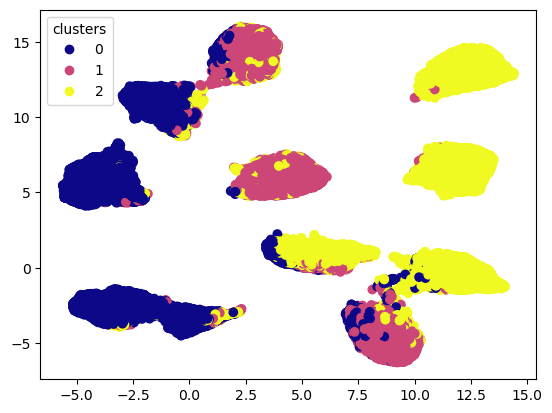

In [134]:
%matplotlib inline
fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=cluster_ids, cmap='plasma')
ax.legend(*sc.legend_elements(), title='clusters')

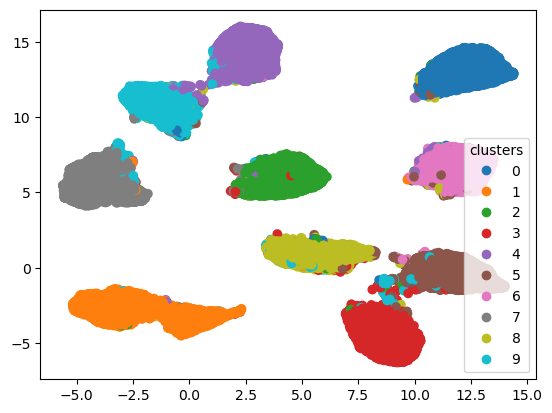

In [135]:
%matplotlib inline

fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

### Increase Clustering coefficient

In [145]:
# trained model and modified training data and labels
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'MNIST'
args.target = -1
args.n_clusters = 3
args.n_classes = 10
args.beta = 10
args.gamma = 2
model, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_gender = train
X_val, y_val_gender = val
X_test, y_test_gender = test

n_clusters 3
alpha 1.0
beta 10
gamma 2
delta 1
eta 0.0
attention 11
Stats:  311670 70000
Dataset dim: (51000, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/MNIST_cnn_feats_-1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/MNIST_cnn_feats_-1_target_-1.pth
Starting Training

[  0/100] train_loss: 2.290 valid_loss: 5.064 valid_F1: 0.020 valid_AUC: 0.533 valid_AUPRC: 0.159 valid_MINPSE: 0.022 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.112
Epoch: 00 | Epoch KM Loss: 4.972 | Total Loss: 302.740 | Classification Loss: 122.106 | Cluster Balance Loss: 3.336
Epoch: 01 | Epoch KM Loss: 8.184 | Total Loss: 287.162 | Classification Loss: 97.155 | Cluster Balance Loss: 1.490

[  2/100] train_loss: 0.587 valid_loss: 1.701 valid_F1: 0.854 valid_AUC: 0.941 valid_AUPRC: 0.756 valid_MINPSE: 0.861 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.287
Epoch: 02 | Epoc

Epoch: 36 | Epoch KM Loss: 10.611 | Total Loss: 116.104 | Classification Loss: 1.610 | Cluster Balance Loss: 1.175
Epoch: 37 | Epoch KM Loss: 10.626 | Total Loss: 116.271 | Classification Loss: 1.717 | Cluster Balance Loss: 1.213

[ 38/100] train_loss: 0.040 valid_loss: 1.315 valid_F1: 0.976 valid_AUC: 0.998 valid_AUPRC: 0.990 valid_MINPSE: 0.976 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.833
EarlyStopping counter: 1 out of 7
Epoch: 38 | Epoch KM Loss: 10.851 | Total Loss: 118.772 | Classification Loss: 1.736 | Cluster Balance Loss: 1.162
Epoch: 39 | Epoch KM Loss: 10.648 | Total Loss: 116.319 | Classification Loss: 1.582 | Cluster Balance Loss: 1.154

[ 40/100] train_loss: 0.047 valid_loss: 1.325 valid_F1: 0.971 valid_AUC: 0.997 valid_AUPRC: 0.987 valid_MINPSE: 0.971 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.840
EarlyStopping counter: 2 out of 7
Epoch: 40 | Epoch KM Loss: 10.603 | Total Loss: 115.040 | Classification Loss: 1.200 | Cluster Balance L

### Get latent embeddings

In [146]:
from tqdm import tqdm
encoded_samples = []
cluster_ids = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0).to(args.device)
    label = sample[1]
    # Encode image
    model.ae.encoder.eval()
    with torch.no_grad():
        _ , z_train = model.encoder_forward(img, output='latent')
        cluster_id, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    # Append to list
    encoded_img = z_train.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    cluster_ids.append(cluster_id[0])
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples, labels = encoded_samples.to_numpy()[:,:4], encoded_samples.to_numpy()[:,4]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:52<00:00, 1135.13it/s]


In [147]:
encoded_samples, labels = encoded_samples.to_numpy()[:,:args.n_z], encoded_samples.to_numpy()[:,args.n_z]
cluster_ids = np.array(cluster_ids)
# print(encoded_samples)

### UMAP embeddings

In [148]:
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(encoded_samples)

In [149]:
label_dict = {}
for idx, val in enumerate(cluster_ids):
    if val in label_dict:
        label_dict[val].append(int(labels[idx]))
    else:
        label_dict[val] = [int(labels[idx])]

In [151]:
for cluster_id in range(args.n_clusters):
    counts = np.bincount(label_dict[cluster_id])
    print("Cluster:", cluster_id, "--", np.where(counts > np.mean(counts))[0])

# Cluster: 0 -- [1 7 9]
# Cluster: 1 -- [2 3 4]
# Cluster: 2 -- [0 5 6 8]

Cluster: 0 -- [1 4 7 9]
Cluster: 1 -- [0 2 3 5]
Cluster: 2 -- [1 2 5 6 8]


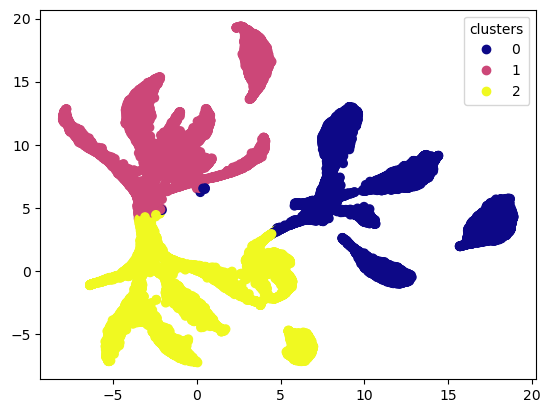

In [152]:
%matplotlib inline
fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=cluster_ids, cmap='plasma')
ax.legend(*sc.legend_elements(), title='clusters')

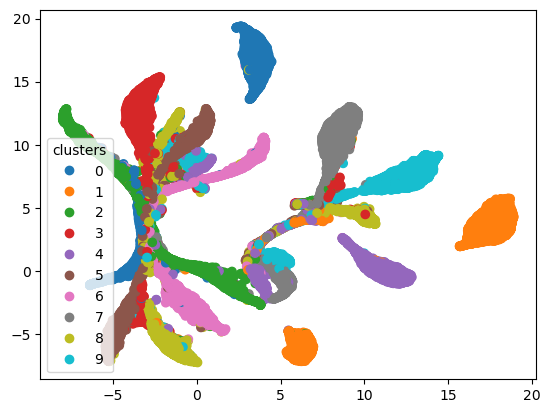

In [153]:
%matplotlib inline

fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

## Fashion MNIST

In [33]:
# trained model and modified training data and labels
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'FashionMNIST'
args.target = -1
args.n_classes = 10
args.verbose = "False"
for j in range(4, 10):
    args.n_clusters = j
    model, train, val, test, column_names = run_ExpertNet(args)
    X_train, y_train_gender = train
    X_val, y_val_gender = val
    X_test, y_test_gender = test

n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  315000 70000
Dataset dim: (51000, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_target_-1.pth
Starting Training

[  0/100] train_loss: 2.254 valid_loss: 3.669 valid_F1: 0.082 valid_AUC: 0.617 valid_AUPRC: 0.172 valid_MINPSE: 0.059 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.253
Epoch: 00 | Epoch KM Loss: 9.682 | Total Loss: 203.159 | Classification Loss: 115.893 | Cluster Balance Loss: 2.749
Epoch: 01 | Epoch KM Loss: 50.657 | Total Loss: 422.321 | Classification Loss: 193.195 | Cluster Balance Loss: 3.404

[  2/100] train_loss: 1.347 valid_loss: 2.078 valid_F1: 0.375 valid_AUC: 0.840 valid_AUPRC: 0.361 valid_MINPSE: 0.377 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: -0.03

Epoch: 37 | Epoch KM Loss: 5.517 | Total Loss: 50.395 | Classification Loss: 22.256 | Cluster Balance Loss: 0.535

[ 38/100] train_loss: 0.289 valid_loss: 0.687 valid_F1: 0.882 valid_AUC: 0.985 valid_AUPRC: 0.915 valid_MINPSE: 0.885 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.802
Epoch: 38 | Epoch KM Loss: 5.973 | Total Loss: 49.797 | Classification Loss: 21.539 | Cluster Balance Loss: 0.477
Epoch: 39 | Epoch KM Loss: 5.842 | Total Loss: 48.543 | Classification Loss: 20.941 | Cluster Balance Loss: 0.561

[ 40/100] train_loss: 0.271 valid_loss: 0.683 valid_F1: 0.880 valid_AUC: 0.983 valid_AUPRC: 0.902 valid_MINPSE: 0.885 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.810
EarlyStopping counter: 1 out of 7
Epoch: 40 | Epoch KM Loss: 5.801 | Total Loss: 47.421 | Classification Loss: 20.110 | Cluster Balance Loss: 0.421
Epoch: 41 | Epoch KM Loss: 5.853 | Total Loss: 46.812 | Classification Loss: 19.803 | Cluster Balance Loss: 0.488

[ 42/100] train_loss: 0.259


[  3/100] valid_loss: 0.325 valid_F1: 0.902 valid_AUC: 0.988 valid_AUPRC: 0.929 valid_MINPSE: 0.902 valid_Sil: 0.831
EarlyStopping counter: 3 out of 7

[  4/100] valid_loss: 0.326 valid_F1: 0.902 valid_AUC: 0.988 valid_AUPRC: 0.928 valid_MINPSE: 0.902 valid_Sil: 0.831
EarlyStopping counter: 4 out of 7

[  5/100] valid_loss: 0.328 valid_F1: 0.902 valid_AUC: 0.988 valid_AUPRC: 0.927 valid_MINPSE: 0.902 valid_Sil: 0.831
EarlyStopping counter: 5 out of 7

[  6/100] valid_loss: 0.331 valid_F1: 0.901 valid_AUC: 0.988 valid_AUPRC: 0.926 valid_MINPSE: 0.901 valid_Sil: 0.831
EarlyStopping counter: 6 out of 7

[  7/100] valid_loss: 0.331 valid_F1: 0.901 valid_AUC: 0.988 valid_AUPRC: 0.925 valid_MINPSE: 0.901 valid_Sil: 0.831
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  3  Attention =  11
Loading Best model with score:  [0.9, 0.933]
{'acc': 0.1, 'auroc': 0.987, 'auprc': 0.926, 'minpse': 0.8

## with different k

In [15]:
for j in range(5, 10):
    args = parameters(params)
    args.ae_type = 'cnn'
    args.dataset = 'FashionMNIST'
    args.target = -1
    args.n_classes = 10
    args.verbose = "False"
    args.n_clusters = j
    model, train, val, test, column_names = run_ExpertNet(args)
    X_train, y_train_gender = train
    X_val, y_val_gender = val
    X_test, y_test_gender = test

KeyboardInterrupt: 

## With different data ratios

In [17]:
# Run Fashion MNIST
data_ratios = [1, 0.9, 0.75, 0.5, 0.4, 0.25, 0.1, 0.01][::-1]
for dr in data_ratios:
    args = parameters(params)
    args.ae_type = 'cnn'
    args.dataset = 'FashionMNIST'
    args.target = -1
    args.n_classes = 10
    args.n_clusters = 3
    print("Data Ratio: ", dr)
    args.data_ratio = dr
    model, train, val, test, column_names = run_ExpertNet(args)

Data Ratio:  0.01
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  47622 10600
Dataset dim: (510, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_dr_0.01_target_-1.pth
CNN_AE(
  (encoder): CNN_Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=20, bias=True)
    )
  )
  (decoder): CNN_Decode

Epoch: 14 | Epoch KM Loss: 0.097 | Total Loss: 2.510 | Classification Loss: 1.513 | Cluster Balance Loss: 2.510
Epoch: 15 | Epoch KM Loss: 0.102 | Total Loss: 2.280 | Classification Loss: 1.356 | Cluster Balance Loss: 2.280

[ 16/100] train_loss: 1.291 valid_loss: 2.340 valid_F1: 0.376 valid_AUC: 0.900 valid_AUPRC: 0.585 valid_MINPSE: 0.410 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.595
Epoch: 16 | Epoch KM Loss: 0.112 | Total Loss: 2.118 | Classification Loss: 1.233 | Cluster Balance Loss: 2.118
Epoch: 17 | Epoch KM Loss: 0.110 | Total Loss: 1.951 | Classification Loss: 1.126 | Cluster Balance Loss: 1.951

[ 18/100] train_loss: 1.053 valid_loss: 2.009 valid_F1: 0.441 valid_AUC: 0.896 valid_AUPRC: 0.587 valid_MINPSE: 0.455 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.593
Epoch: 18 | Epoch KM Loss: 0.103 | Total Loss: 1.784 | Classification Loss: 1.023 | Cluster Balance Loss: 1.784
Epoch: 19 | Epoch KM Loss: 0.104 | Total Loss: 1.676 | Classification Lo

Epoch: 54 | Epoch KM Loss: 0.084 | Total Loss: 0.804 | Classification Loss: 0.348 | Cluster Balance Loss: 0.804
Epoch: 55 | Epoch KM Loss: 0.082 | Total Loss: 0.774 | Classification Loss: 0.335 | Cluster Balance Loss: 0.774

[ 56/100] train_loss: 0.311 valid_loss: 1.627 valid_F1: 0.744 valid_AUC: 0.943 valid_AUPRC: 0.760 valid_MINPSE: 0.761 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.587
Epoch: 56 | Epoch KM Loss: 0.086 | Total Loss: 0.756 | Classification Loss: 0.322 | Cluster Balance Loss: 0.756
Epoch: 57 | Epoch KM Loss: 0.084 | Total Loss: 0.725 | Classification Loss: 0.313 | Cluster Balance Loss: 0.725

[ 58/100] train_loss: 0.333 valid_loss: 1.698 valid_F1: 0.749 valid_AUC: 0.944 valid_AUPRC: 0.760 valid_MINPSE: 0.769 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.581
Epoch: 58 | Epoch KM Loss: 0.089 | Total Loss: 0.708 | Classification Loss: 0.303 | Cluster Balance Loss: 0.708
Epoch: 59 | Epoch KM Loss: 0.083 | Total Loss: 0.663 | Classification Lo


[ 12/100] valid_loss: 0.868 valid_F1: 0.770 valid_AUC: 0.949 valid_AUPRC: 0.772 valid_MINPSE: 0.774 valid_Sil: 0.605
EarlyStopping counter: 6 out of 7

[ 13/100] valid_loss: 0.861 valid_F1: 0.770 valid_AUC: 0.950 valid_AUPRC: 0.771 valid_MINPSE: 0.774 valid_Sil: 0.605
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  3  Attention =  11
Loading Best model with score:  [0.802, 0.778]
{'acc': 0.108, 'auroc': 0.941, 'auprc': 0.69, 'minpse': 0.773, 'f1_score': 0.77, 'e_test_loss': tensor(0.9360, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 1.031, E-Test Loss 0.936
Classification Metrics - Test F1 0.763, Test AUC 0.935, Test AUPRC 0.681, Test MIN_PSE 0.766 
E-Test F1 0.770, E-Test AUC 0.941, E-Test AUPRC 0.690, E-Test MIN_PSE 0.773


Data Ratio:  0.1
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  71945 16000
Dataset dim: (5100, 1, 28, 28)
Run : 0
/


[ 10/100] train_loss: 7.564 valid_loss: 7.692 valid_F1: 0.056 valid_AUC: 0.777 valid_AUPRC: 0.293 valid_MINPSE: 0.098 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.000
EarlyStopping counter: 3 out of 7
Epoch: 10 | Epoch KM Loss: 0.158 | Total Loss: 43.200 | Classification Loss: 26.951 | Cluster Balance Loss: 3.894
Epoch: 11 | Epoch KM Loss: 0.231 | Total Loss: 39.305 | Classification Loss: 24.194 | Cluster Balance Loss: 3.518

[ 12/100] train_loss: 2.242 valid_loss: 3.605 valid_F1: 0.095 valid_AUC: 0.747 valid_AUPRC: 0.274 valid_MINPSE: 0.101 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.000
EarlyStopping counter: 4 out of 7
Epoch: 12 | Epoch KM Loss: 0.003 | Total Loss: 33.503 | Classification Loss: 21.039 | Cluster Balance Loss: 3.243
Epoch: 13 | Epoch KM Loss: 0.013 | Total Loss: 31.236 | Classification Loss: 19.852 | Cluster Balance Loss: 2.955

[ 14/100] train_loss: 1.776 valid_loss: 2.930 valid_F1: 0.163 valid_AUC: 0.786 valid_AUPRC: 0.300 valid_MIN

Pretraining epoch 0 loss=0.1288
Pretraining epoch 1 loss=0.0809
Pretraining epoch 2 loss=0.0554
Pretraining epoch 3 loss=0.0413
Pretraining epoch 4 loss=0.0328
Pretraining epoch 5 loss=0.0276
Pretraining epoch 6 loss=0.0243
Pretraining epoch 7 loss=0.0223
Pretraining epoch 8 loss=0.0209
Pretraining epoch 9 loss=0.0198
Pretraining epoch 10 loss=0.0189
Pretraining epoch 11 loss=0.0183
Pretraining epoch 12 loss=0.0177
Pretraining epoch 13 loss=0.0171
Pretraining epoch 14 loss=0.0167
Pretraining epoch 15 loss=0.0162
Pretraining epoch 16 loss=0.0159
Pretraining epoch 17 loss=0.0156
Pretraining epoch 18 loss=0.0153
Pretraining epoch 19 loss=0.0150
Pretraining epoch 20 loss=0.0147
Pretraining epoch 21 loss=0.0146
Pretraining epoch 22 loss=0.0143
Pretraining epoch 23 loss=0.0142
Pretraining epoch 24 loss=0.0141
Pretraining epoch 25 loss=0.0138
Pretraining epoch 26 loss=0.0137
Pretraining epoch 27 loss=0.0137
Pretraining epoch 28 loss=0.0135
Pretraining epoch 29 loss=0.0133
Pretraining epoch 30


[  4/100] valid_loss: 0.524 valid_F1: 0.786 valid_AUC: 0.949 valid_AUPRC: 0.736 valid_MINPSE: 0.791 valid_Sil: 0.450

[  5/100] valid_loss: 0.521 valid_F1: 0.791 valid_AUC: 0.950 valid_AUPRC: 0.735 valid_MINPSE: 0.797 valid_Sil: 0.450
EarlyStopping counter: 1 out of 7

[  6/100] valid_loss: 0.518 valid_F1: 0.793 valid_AUC: 0.950 valid_AUPRC: 0.735 valid_MINPSE: 0.800 valid_Sil: 0.450
EarlyStopping counter: 2 out of 7

[  7/100] valid_loss: 0.516 valid_F1: 0.795 valid_AUC: 0.950 valid_AUPRC: 0.735 valid_MINPSE: 0.802 valid_Sil: 0.450
EarlyStopping counter: 3 out of 7

[  8/100] valid_loss: 0.514 valid_F1: 0.795 valid_AUC: 0.951 valid_AUPRC: 0.734 valid_MINPSE: 0.802 valid_Sil: 0.450
EarlyStopping counter: 4 out of 7

[  9/100] valid_loss: 0.513 valid_F1: 0.798 valid_AUC: 0.951 valid_AUPRC: 0.734 valid_MINPSE: 0.805 valid_Sil: 0.450
EarlyStopping counter: 5 out of 7

[ 10/100] valid_loss: 0.511 valid_F1: 0.800 valid_AUC: 0.951 valid_AUPRC: 0.735 valid_MINPSE: 0.807 valid_Sil: 0.450
Earl


[  6/100] train_loss: 0.428 valid_loss: 0.931 valid_F1: 0.842 valid_AUC: 0.960 valid_AUPRC: 0.755 valid_MINPSE: 0.849 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.432
Epoch: 06 | Epoch KM Loss: 3.072 | Total Loss: 32.274 | Classification Loss: 16.007 | Cluster Balance Loss: 0.861
Epoch: 07 | Epoch KM Loss: 11.346 | Total Loss: 88.798 | Classification Loss: 38.981 | Cluster Balance Loss: 4.041

[  8/100] train_loss: 2.155 valid_loss: 3.443 valid_F1: 0.331 valid_AUC: 0.854 valid_AUPRC: 0.441 valid_MINPSE: 0.477 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.257
EarlyStopping counter: 1 out of 7
Epoch: 08 | Epoch KM Loss: 1.954 | Total Loss: 143.428 | Classification Loss: 87.521 | Cluster Balance Loss: 3.328
Epoch: 09 | Epoch KM Loss: 1.764 | Total Loss: 144.911 | Classification Loss: 89.972 | Cluster Balance Loss: 3.776

[ 10/100] train_loss: 2.326 valid_loss: 3.376 valid_F1: 0.110 valid_AUC: 0.803 valid_AUPRC: 0.365 valid_MINPSE: 0.215 valid_Feature_p: 0.0

Pretraining epoch 26 loss=0.0127
Pretraining epoch 27 loss=0.0125
Pretraining epoch 28 loss=0.0125
Pretraining epoch 29 loss=0.0123
Pretraining epoch 30 loss=0.0122
Pretraining epoch 31 loss=0.0122
Pretraining epoch 32 loss=0.0121
Pretraining epoch 33 loss=0.0120
Pretraining epoch 34 loss=0.0120
Pretraining epoch 35 loss=0.0119
Pretraining epoch 36 loss=0.0119
Pretraining epoch 37 loss=0.0117
Pretraining epoch 38 loss=0.0117
Pretraining epoch 39 loss=0.0117
Pretraining epoch 40 loss=0.0117
Pretraining epoch 41 loss=0.0116
Pretraining epoch 42 loss=0.0116
Pretraining epoch 43 loss=0.0115
Pretraining epoch 44 loss=0.0115
Pretraining epoch 45 loss=0.0113
Pretraining epoch 46 loss=0.0114
Pretraining epoch 47 loss=0.0113
Pretraining epoch 48 loss=0.0113
Pretraining epoch 49 loss=0.0113
Pretraining epoch 50 loss=0.0112
Pretraining epoch 51 loss=0.0112
Pretraining epoch 52 loss=0.0112
Pretraining epoch 53 loss=0.0111
Pretraining epoch 54 loss=0.0112
Pretraining epoch 55 loss=0.0111
Pretrainin

{'acc': 0.109, 'auroc': 0.952, 'auprc': 0.74, 'minpse': 0.832, 'f1_score': 0.832, 'e_test_loss': tensor(0.4480, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.451, E-Test Loss 0.448
Classification Metrics - Test F1 0.832, Test AUC 0.953, Test AUPRC 0.718, Test MIN_PSE 0.832 
E-Test F1 0.832, E-Test AUC 0.952, E-Test AUPRC 0.740, E-Test MIN_PSE 0.832


Data Ratio:  0.75
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  247178 55000
Dataset dim: (38250, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_dr_0.75_target_-1.pth
CNN_AE(
  (encoder): CNN_Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=Tr


[ 12/100] train_loss: 1.659 valid_loss: 1.900 valid_F1: 0.567 valid_AUC: 0.773 valid_AUPRC: 0.318 valid_MINPSE: 0.547 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.339
EarlyStopping counter: 3 out of 7
Epoch: 12 | Epoch KM Loss: 0.005 | Total Loss: 188.476 | Classification Loss: 122.370 | Cluster Balance Loss: 2.662
Epoch: 13 | Epoch KM Loss: 0.032 | Total Loss: 222.349 | Classification Loss: 144.400 | Cluster Balance Loss: 2.883

[ 14/100] train_loss: 1.704 valid_loss: 2.588 valid_F1: 0.211 valid_AUC: 0.728 valid_AUPRC: 0.246 valid_MINPSE: 0.166 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.000
EarlyStopping counter: 4 out of 7
Epoch: 14 | Epoch KM Loss: 0.000 | Total Loss: 208.952 | Classification Loss: 136.236 | Cluster Balance Loss: 2.761
Epoch: 15 | Epoch KM Loss: 0.000 | Total Loss: 201.425 | Classification Loss: 131.483 | Cluster Balance Loss: 2.633

[ 16/100] train_loss: 1.475 valid_loss: 2.370 valid_F1: 0.234 valid_AUC: 0.727 valid_AUPRC: 0.256 v


[ 51/100] valid_loss: 0.494 valid_F1: 0.803 valid_AUC: 0.934 valid_AUPRC: 0.657 valid_MINPSE: 0.806 valid_Sil: 0.410

[ 52/100] valid_loss: 0.492 valid_F1: 0.804 valid_AUC: 0.934 valid_AUPRC: 0.658 valid_MINPSE: 0.805 valid_Sil: 0.410

[ 53/100] valid_loss: 0.487 valid_F1: 0.810 valid_AUC: 0.935 valid_AUPRC: 0.658 valid_MINPSE: 0.809 valid_Sil: 0.410

[ 54/100] valid_loss: 0.486 valid_F1: 0.808 valid_AUC: 0.935 valid_AUPRC: 0.659 valid_MINPSE: 0.807 valid_Sil: 0.410

[ 55/100] valid_loss: 0.487 valid_F1: 0.809 valid_AUC: 0.935 valid_AUPRC: 0.658 valid_MINPSE: 0.809 valid_Sil: 0.410
EarlyStopping counter: 1 out of 7

[ 56/100] valid_loss: 0.486 valid_F1: 0.808 valid_AUC: 0.935 valid_AUPRC: 0.660 valid_MINPSE: 0.809 valid_Sil: 0.410

[ 57/100] valid_loss: 0.484 valid_F1: 0.811 valid_AUC: 0.935 valid_AUPRC: 0.661 valid_MINPSE: 0.810 valid_Sil: 0.410

[ 58/100] valid_loss: 0.484 valid_F1: 0.810 valid_AUC: 0.935 valid_AUPRC: 0.661 valid_MINPSE: 0.809 valid_Sil: 0.410

[ 59/100] valid_loss:

Pretraining epoch 0 loss=0.0830
Pretraining epoch 1 loss=0.0333
Pretraining epoch 2 loss=0.0216
Pretraining epoch 3 loss=0.0184
Pretraining epoch 4 loss=0.0166
Pretraining epoch 5 loss=0.0154
Pretraining epoch 6 loss=0.0147
Pretraining epoch 7 loss=0.0140
Pretraining epoch 8 loss=0.0135
Pretraining epoch 9 loss=0.0132
Pretraining epoch 10 loss=0.0129
Pretraining epoch 11 loss=0.0127
Pretraining epoch 12 loss=0.0124
Pretraining epoch 13 loss=0.0122
Pretraining epoch 14 loss=0.0122
Pretraining epoch 15 loss=0.0119
Pretraining epoch 16 loss=0.0118
Pretraining epoch 17 loss=0.0116
Pretraining epoch 18 loss=0.0115
Pretraining epoch 19 loss=0.0114
Pretraining epoch 20 loss=0.0114
Pretraining epoch 21 loss=0.0112
Pretraining epoch 22 loss=0.0112
Pretraining epoch 23 loss=0.0111
Pretraining epoch 24 loss=0.0111
Pretraining epoch 25 loss=0.0110
Pretraining epoch 26 loss=0.0109
Pretraining epoch 27 loss=0.0109
Pretraining epoch 28 loss=0.0108
Pretraining epoch 29 loss=0.0107
Pretraining epoch 30

Epoch: 22 | Epoch KM Loss: 6.245 | Total Loss: 47.331 | Classification Loss: 19.825 | Cluster Balance Loss: 0.454
Epoch: 23 | Epoch KM Loss: 5.098 | Total Loss: 42.742 | Classification Loss: 18.197 | Cluster Balance Loss: 0.524

[ 24/100] train_loss: 0.225 valid_loss: 0.637 valid_F1: 0.895 valid_AUC: 0.986 valid_AUPRC: 0.924 valid_MINPSE: 0.900 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.818
Epoch: 24 | Epoch KM Loss: 5.709 | Total Loss: 42.136 | Classification Loss: 17.146 | Cluster Balance Loss: 0.414
Epoch: 25 | Epoch KM Loss: 6.548 | Total Loss: 44.113 | Classification Loss: 17.253 | Cluster Balance Loss: 0.671

[ 26/100] train_loss: 0.239 valid_loss: 0.754 valid_F1: 0.890 valid_AUC: 0.979 valid_AUPRC: 0.899 valid_MINPSE: 0.891 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.795
EarlyStopping counter: 1 out of 7
Epoch: 26 | Epoch KM Loss: 4.193 | Total Loss: 39.645 | Classification Loss: 17.496 | Cluster Balance Loss: 0.473
Epoch: 27 | Epoch KM Loss: 3


[  6/100] valid_loss: 0.343 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.945 valid_MINPSE: 0.906 valid_Sil: 0.830

[  7/100] valid_loss: 0.347 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.944 valid_MINPSE: 0.906 valid_Sil: 0.830
EarlyStopping counter: 1 out of 7

[  8/100] valid_loss: 0.349 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.944 valid_MINPSE: 0.905 valid_Sil: 0.830
EarlyStopping counter: 2 out of 7

[  9/100] valid_loss: 0.349 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.944 valid_MINPSE: 0.905 valid_Sil: 0.830
EarlyStopping counter: 3 out of 7

[ 10/100] valid_loss: 0.350 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.944 valid_MINPSE: 0.906 valid_Sil: 0.830
EarlyStopping counter: 4 out of 7

[ 11/100] valid_loss: 0.351 valid_F1: 0.905 valid_AUC: 0.990 valid_AUPRC: 0.944 valid_MINPSE: 0.905 valid_Sil: 0.830
EarlyStopping counter: 5 out of 7

[ 12/100] valid_loss: 0.352 valid_F1: 0.906 valid_AUC: 0.990 valid_AUPRC: 0.943 valid_MINPSE: 0.905 valid_Sil: 0.830
Earl


[  6/100] train_loss: 0.381 valid_loss: 0.814 valid_F1: 0.853 valid_AUC: 0.967 valid_AUPRC: 0.819 valid_MINPSE: 0.856 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.493
Epoch: 06 | Epoch KM Loss: 4.583 | Total Loss: 71.652 | Classification Loss: 37.526 | Cluster Balance Loss: 0.784
Epoch: 07 | Epoch KM Loss: 5.029 | Total Loss: 71.334 | Classification Loss: 36.797 | Cluster Balance Loss: 0.621

[  8/100] train_loss: 0.336 valid_loss: 0.712 valid_F1: 0.874 valid_AUC: 0.974 valid_AUPRC: 0.852 valid_MINPSE: 0.875 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.586
Epoch: 08 | Epoch KM Loss: 16.484 | Total Loss: 100.871 | Classification Loss: 39.899 | Cluster Balance Loss: 1.399
Epoch: 09 | Epoch KM Loss: 23.586 | Total Loss: 155.928 | Classification Loss: 64.950 | Cluster Balance Loss: 0.837

[ 10/100] train_loss: 0.435 valid_loss: 0.865 valid_F1: 0.838 valid_AUC: 0.963 valid_AUPRC: 0.810 valid_MINPSE: 0.838 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhou

Epoch: 44 | Epoch KM Loss: 4.385 | Total Loss: 40.140 | Classification Loss: 17.355 | Cluster Balance Loss: 0.396
Epoch: 45 | Epoch KM Loss: 4.276 | Total Loss: 38.874 | Classification Loss: 16.598 | Cluster Balance Loss: 0.392

[ 46/100] train_loss: 0.205 valid_loss: 0.583 valid_F1: 0.902 valid_AUC: 0.987 valid_AUPRC: 0.926 valid_MINPSE: 0.903 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.828
EarlyStopping counter: 2 out of 7
Epoch: 46 | Epoch KM Loss: 4.382 | Total Loss: 39.540 | Classification Loss: 16.880 | Cluster Balance Loss: 0.430
Epoch: 47 | Epoch KM Loss: 4.049 | Total Loss: 37.206 | Classification Loss: 15.844 | Cluster Balance Loss: 0.351

[ 48/100] train_loss: 0.196 valid_loss: 0.590 valid_F1: 0.902 valid_AUC: 0.987 valid_AUPRC: 0.922 valid_MINPSE: 0.903 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.833
EarlyStopping counter: 3 out of 7
Epoch: 48 | Epoch KM Loss: 4.266 | Total Loss: 38.000 | Classification Loss: 16.116 | Cluster Balance Loss: 


[  8/100] valid_loss: 0.314 valid_F1: 0.905 valid_AUC: 0.990 valid_AUPRC: 0.939 valid_MINPSE: 0.905 valid_Sil: 0.839
EarlyStopping counter: 4 out of 7

[  9/100] valid_loss: 0.315 valid_F1: 0.906 valid_AUC: 0.989 valid_AUPRC: 0.939 valid_MINPSE: 0.906 valid_Sil: 0.839
EarlyStopping counter: 5 out of 7

[ 10/100] valid_loss: 0.315 valid_F1: 0.905 valid_AUC: 0.990 valid_AUPRC: 0.939 valid_MINPSE: 0.905 valid_Sil: 0.839
EarlyStopping counter: 6 out of 7

[ 11/100] valid_loss: 0.317 valid_F1: 0.906 valid_AUC: 0.989 valid_AUPRC: 0.939 valid_MINPSE: 0.906 valid_Sil: 0.839
EarlyStopping counter: 7 out of 7

####################################################################################

Evaluating Test Data with k =  3  Attention =  11
Loading Best model with score:  [0.905, 0.941]
{'acc': 0.104, 'auroc': 0.989, 'auprc': 0.934, 'minpse': 0.9, 'f1_score': 0.9, 'e_test_loss': tensor(0.3310, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.332, E-Test Loss 0.331
Classification M

In [16]:
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'FashionMNIST'
args.target = -1
args.n_classes = 10
args.n_clusters = 3
dr = 0.1
print("Data Ratio: ", dr)
args.data_ratio = dr
model, train, val, test, column_names = run_ExpertNet(args)

Data Ratio:  0.1
n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Stats:  31538 7000
Dataset dim: (5100, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_dr_0.1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_dr_0.1_target_-1.pth
Starting Training

[  0/100] train_loss: 2.265 valid_loss: 3.662 valid_F1: 0.021 valid_AUC: 0.583 valid_AUPRC: 0.167 valid_MINPSE: 0.138 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.281
Epoch: 00 | Epoch KM Loss: 0.749 | Total Loss: 35.370 | Classification Loss: 21.986 | Cluster Balance Loss: 3.288
Epoch: 01 | Epoch KM Loss: 0.331 | Total Loss: 29.565 | Classification Loss: 18.861 | Cluster Balance Loss: 2.688

[  2/100] train_loss: 1.623 valid_loss: 2.735 valid_F1: 0.238 valid_AUC: 0.843 valid_AUPRC: 0.357 valid_MINPSE: 0.332 valid_Feature_p: 0.000 valid_WDFD: 0.000 

Epoch: 37 | Epoch KM Loss: 1.323 | Total Loss: 8.188 | Classification Loss: 3.187 | Cluster Balance Loss: 0.741

[ 38/100] train_loss: 0.312 valid_loss: 1.012 valid_F1: 0.841 valid_AUC: 0.962 valid_AUPRC: 0.805 valid_MINPSE: 0.843 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.711
EarlyStopping counter: 1 out of 7
Epoch: 38 | Epoch KM Loss: 1.129 | Total Loss: 7.283 | Classification Loss: 2.883 | Cluster Balance Loss: 0.729
Epoch: 39 | Epoch KM Loss: 1.381 | Total Loss: 7.926 | Classification Loss: 2.962 | Cluster Balance Loss: 0.758

[ 40/100] train_loss: 0.286 valid_loss: 1.047 valid_F1: 0.847 valid_AUC: 0.964 valid_AUPRC: 0.808 valid_MINPSE: 0.849 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.719
EarlyStopping counter: 2 out of 7
Epoch: 40 | Epoch KM Loss: 1.139 | Total Loss: 6.956 | Classification Loss: 2.659 | Cluster Balance Loss: 0.654
Epoch: 41 | Epoch KM Loss: 0.872 | Total Loss: 6.112 | Classification Loss: 2.375 | Cluster Balance Loss: 0.556

[ 4

Epoch: 76 | Epoch KM Loss: 1.112 | Total Loss: 2.929 | Classification Loss: 0.131 | Cluster Balance Loss: 0.298
Epoch: 77 | Epoch KM Loss: 1.060 | Total Loss: 2.918 | Classification Loss: 0.153 | Cluster Balance Loss: 0.328

[ 78/100] train_loss: 0.049 valid_loss: 2.237 valid_F1: 0.843 valid_AUC: 0.970 valid_AUPRC: 0.853 valid_MINPSE: 0.846 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.812
EarlyStopping counter: 2 out of 7
Epoch: 78 | Epoch KM Loss: 1.097 | Total Loss: 3.040 | Classification Loss: 0.180 | Cluster Balance Loss: 0.307
Epoch: 79 | Epoch KM Loss: 1.104 | Total Loss: 2.946 | Classification Loss: 0.131 | Cluster Balance Loss: 0.299

[ 80/100] train_loss: 0.067 valid_loss: 2.237 valid_F1: 0.849 valid_AUC: 0.972 valid_AUPRC: 0.868 valid_MINPSE: 0.851 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.817
EarlyStopping counter: 3 out of 7
Epoch: 80 | Epoch KM Loss: 1.085 | Total Loss: 2.976 | Classification Loss: 0.155 | Cluster Balance Loss: 0.329
Epoc

### Get latent Embeddings

In [29]:
from tqdm import tqdm
train_dataset = generate_data_loaders(X_train, y_train_gender, 1)
encoded_samples = []
cluster_ids = []
for sample in tqdm(train_dataset):
    img = sample[0].to(args.device)
    label = sample[1]
    # Encode image
    model.ae.encoder.eval()
    with torch.no_grad():
        _ , z_train = model.encoder_forward(img, output='latent')
        cluster_id, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    # Append to list
    encoded_img = z_train.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    cluster_ids.append(cluster_id[0])
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples, labels = encoded_samples.to_numpy()[:,:4], encoded_samples.to_numpy()[:,4]

encoded_samples, labels = encoded_samples.to_numpy()[:,:args.n_z], encoded_samples.to_numpy()[:,args.n_z]
cluster_ids = np.array(cluster_ids)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 51000/51000 [00:47<00:00, 1078.10it/s]


In [30]:
### UMAP embeddings
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(encoded_samples)

In [31]:
label_dict = {}
for idx, val in enumerate(cluster_ids):
    if val in label_dict:
        label_dict[val].append(int(labels[idx]))
    else:
        label_dict[val] = [int(labels[idx])]

for cluster_id in range(args.n_clusters):
    counts = np.bincount(label_dict[cluster_id])
    print("Cluster:", cluster_id, "--", np.where(counts > np.mean(counts))[0])

Cluster: 0 -- [0 1 3]
Cluster: 1 -- [2 4 6 8]
Cluster: 2 -- [5 7 9]


Cluster: 0 -- [Top, Trouser, Dress]

Cluster: 1 -- [Pullover, Coat, Shirt, bag]

Cluster: 2 -- [Sandle, Sneaker, Boot]

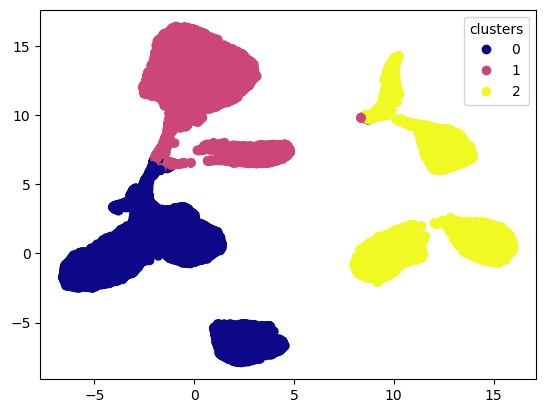

In [32]:
%matplotlib inline
fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=cluster_ids, cmap='plasma')
ax.legend(*sc.legend_elements(), title='clusters')

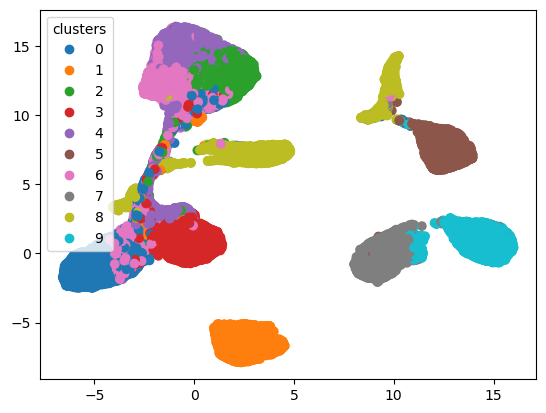

In [33]:
%matplotlib inline

fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

In [36]:
'''
Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
'''

'\nLabel\tDescription\n0\tT-shirt/top\n1\tTrouser\n2\tPullover\n3\tDress\n4\tCoat\n5\tSandal\n6\tShirt\n7\tSneaker\n8\tBag\n9\tAnkle boot\n'

### k = 1

In [32]:
# trained model and modified training data and labels
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'FashionMNIST'
args.target = -1
args.n_clusters = 1
args.n_classes = 10
args.alpha, args.beta, args.gamma, args.delta = 0, 0, 1, 0
model, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_gender = train
X_val, y_val_gender = val
X_test, y_test_gender = test

n_clusters 1
alpha 0
beta 0
gamma 1
delta 0
eta 0.0
attention 11
Stats:  315000 70000
Dataset dim: (51000, 1, 28, 28)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_target_-1.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/FashionMNIST_cnn_feats_-1_target_-1.pth
Starting Training

[  0/100] train_loss: 2.313 valid_loss: 2.313 valid_F1: 0.018 valid_AUC: 0.472 valid_AUPRC: 0.101 valid_MINPSE: 0.001 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.000
Epoch: 00 | Epoch KM Loss: 0.000 | Total Loss: 166.043 | Classification Loss: 166.043 | Cluster Balance Loss: 2.231
Epoch: 01 | Epoch KM Loss: 0.000 | Total Loss: 243.680 | Classification Loss: 243.680 | Cluster Balance Loss: 2.259

[  2/100] train_loss: 2.032 valid_loss: 2.030 valid_F1: 0.107 valid_AUC: 0.769 valid_AUPRC: 0.279 valid_MINPSE: 0.128 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.000
Epoc


[ 33/100] valid_loss: 1.015 valid_F1: 0.586 valid_AUC: 0.842 valid_AUPRC: 0.420 valid_MINPSE: 0.594 valid_Sil: 0.000

[ 34/100] valid_loss: 1.020 valid_F1: 0.581 valid_AUC: 0.843 valid_AUPRC: 0.425 valid_MINPSE: 0.593 valid_Sil: 0.000

[ 35/100] valid_loss: 1.006 valid_F1: 0.587 valid_AUC: 0.845 valid_AUPRC: 0.429 valid_MINPSE: 0.595 valid_Sil: 0.000

[ 36/100] valid_loss: 0.998 valid_F1: 0.597 valid_AUC: 0.846 valid_AUPRC: 0.432 valid_MINPSE: 0.605 valid_Sil: 0.000

[ 37/100] valid_loss: 0.996 valid_F1: 0.594 valid_AUC: 0.847 valid_AUPRC: 0.435 valid_MINPSE: 0.604 valid_Sil: 0.000

[ 38/100] valid_loss: 0.983 valid_F1: 0.601 valid_AUC: 0.848 valid_AUPRC: 0.437 valid_MINPSE: 0.609 valid_Sil: 0.000

[ 39/100] valid_loss: 0.974 valid_F1: 0.605 valid_AUC: 0.849 valid_AUPRC: 0.440 valid_MINPSE: 0.611 valid_Sil: 0.000

[ 40/100] valid_loss: 0.970 valid_F1: 0.607 valid_AUC: 0.850 valid_AUPRC: 0.441 valid_MINPSE: 0.614 valid_Sil: 0.000

[ 41/100] valid_loss: 0.964 valid_F1: 0.609 valid_AUC: 

{'acc': 0.1192, 'auroc': 0.8921413444444445, 'auprc': 0.5402242083455413, 'minpse': 0.6844758174801004, 'f1_score': 0.6708590814646247, 'e_test_loss': tensor(0.8153, grad_fn=<MeanBackward0>)}
Run #0
Loss Metrics - Test Loss 0.815, E-Test Loss 0.815
Classification Metrics - Test F1 0.671, Test AUC 0.892, Test AUPRC 0.540, Test MIN_PSE 0.684 
E-Test F1 0.671, E-Test AUC 0.892, E-Test AUPRC 0.540, E-Test MIN_PSE 0.684




In [36]:
### Get latent embeddings
from tqdm import tqdm
train_dataset = generate_data_loaders(X_train, y_train_gender, 1)
encoded_samples = []
cluster_ids = []
for sample in tqdm(train_dataset):
    img = sample[0].to(args.device)
    label = sample[1]
    # Encode image
    model.ae.encoder.eval()
    with torch.no_grad():
        _ , z_train = model.encoder_forward(img, output='latent')
        cluster_id, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    # Append to list
    encoded_img = z_train.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    cluster_ids.append(cluster_id[0])
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples, labels = encoded_samples.to_numpy()[:,:4], encoded_samples.to_numpy()[:,4]

encoded_samples, labels = encoded_samples.to_numpy()[:,:args.n_z], encoded_samples.to_numpy()[:,args.n_z]
cluster_ids = np.array(cluster_ids)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 51000/51000 [09:26<00:00, 90.04it/s]


In [46]:
### UMAP embeddings
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(encoded_samples)

In [47]:
label_dict = {}
for idx, val in enumerate(cluster_ids):
    if val in label_dict:
        label_dict[val].append(int(labels[idx]))
    else:
        label_dict[val] = [int(labels[idx])]

for cluster_id in range(args.n_clusters):
    counts = np.bincount(label_dict[cluster_id])
    print("Cluster:", cluster_id, "--", np.where(counts > np.mean(counts))[0])

Cluster: 0 -- [0 1 6 7 8]


Cluster: 0 -- [Top, Trouser, Dress]

Cluster: 1 -- [Pullover, Coat, Shirt, bag]

Cluster: 2 -- [Sandle, Sneaker, Boot]

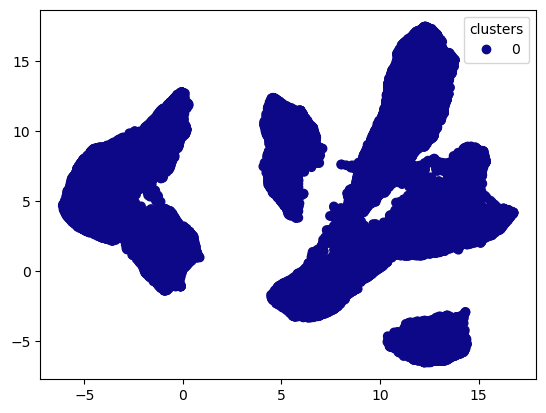

In [48]:
%matplotlib inline
fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=cluster_ids, cmap='plasma')
ax.legend(*sc.legend_elements(), title='clusters')

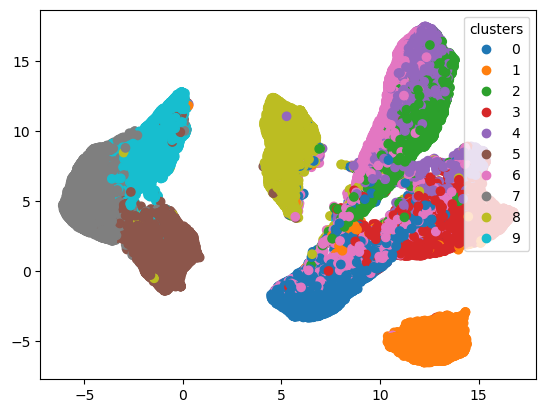

In [49]:
%matplotlib inline

fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

## CIFAR-10

In [21]:
# trained model and modified training data and labels
args = parameters(params)
args.ae_type = 'cnn'
args.dataset = 'CIFAR10'
args.target = -1
args.n_clusters = 3
args.n_classes = 10
args.n_channels = 3
args.input_dim = 32
model, train, val, test, column_names = run_ExpertNet(args)
X_train, y_train_gender = train
X_val, y_val_gender = val
X_test, y_test_gender = test

n_clusters 3
alpha 1.0
beta 2
gamma 1.5
delta 1
eta 0.0
attention 11
Files already downloaded and verified
Files already downloaded and verified
Stats:  270000 60000
Dataset dim: (42500, 3, 32, 32)
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/CIFAR10_cnn_feats_-1_target_-1.pth
CNN_AE(
  (encoder): CNN_Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/models.py:159: UserWarning: Using a target size (torch.Size([512, 3, 32, 32])) that is different to the input size (torch.Size([512, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x_bar, x)


RuntimeError: The size of tensor a (28) must match the size of tensor b (32) at non-singleton dimension 3

In [19]:
expertnet_ae = CNN_AE(encoded_space_dim=args.n_z, fc2_input_dim=128, n_channels=args.n_channels)

In [31]:
print(expertnet_ae.encoder.encoder_cnn)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (6): ReLU(inplace=True)
)


In [29]:
### Get latent embeddings
from tqdm import tqdm
train_dataset = generate_data_loaders(X_train, y_train_gender, 1)
encoded_samples = []
cluster_ids = []
for sample in tqdm(train_dataset):
    img = sample[0].to(args.device)
    label = sample[1]
    # Encode image
    model.ae.encoder.eval()
    with torch.no_grad():
        _ , z_train = model.encoder_forward(img, output='latent')
        cluster_id, _ = vq(z_train.data.cpu().numpy(), model.cluster_layer.cpu().numpy())

    # Append to list
    encoded_img = z_train.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    cluster_ids.append(cluster_id[0])
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples, labels = encoded_samples.to_numpy()[:,:4], encoded_samples.to_numpy()[:,4]

encoded_samples, labels = encoded_samples.to_numpy()[:,:args.n_z], encoded_samples.to_numpy()[:,args.n_z]
cluster_ids = np.array(cluster_ids)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 51000/51000 [00:47<00:00, 1078.10it/s]


In [30]:
### UMAP embeddings
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(encoded_samples)

In [31]:
label_dict = {}
for idx, val in enumerate(cluster_ids):
    if val in label_dict:
        label_dict[val].append(int(labels[idx]))
    else:
        label_dict[val] = [int(labels[idx])]

for cluster_id in range(args.n_clusters):
    counts = np.bincount(label_dict[cluster_id])
    print("Cluster:", cluster_id, "--", np.where(counts > np.mean(counts))[0])

Cluster: 0 -- [0 1 3]
Cluster: 1 -- [2 4 6 8]
Cluster: 2 -- [5 7 9]


Cluster: 0 -- [Top, Trouser, Dress]

Cluster: 1 -- [Pullover, Coat, Shirt, bag]

Cluster: 2 -- [Sandle, Sneaker, Boot]

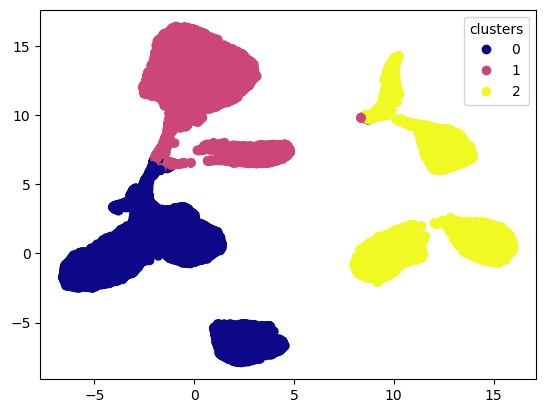

In [32]:
%matplotlib inline
fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=cluster_ids, cmap='plasma')
ax.legend(*sc.legend_elements(), title='clusters')

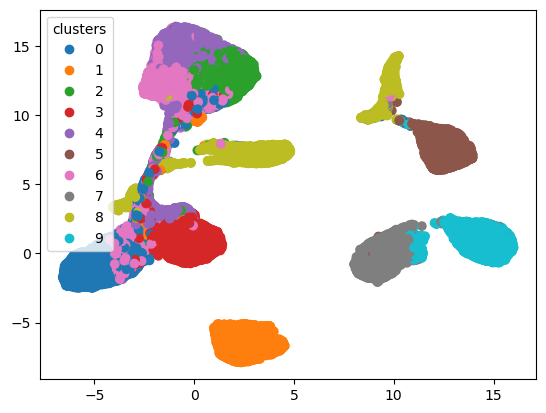

In [33]:
%matplotlib inline

fig, ax = plt.subplots()
sc = ax.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

## Single CNN classifier

In [23]:
args = parameters(params)
scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=0, n_features=args.n_features)
X_train, y_train = train_data
X_val, y_val = val_data
X_test, y_test = test_data

train_loader = generate_data_loaders(X_train, y_train, args.batch_size)
val_loader = generate_data_loaders(X_val, y_val, args.batch_size)
test_loader = generate_data_loaders(X_test, y_test, args.batch_size)

[288, 128, 64, 32, 16, 10]


In [25]:
args.ae_type = 'cnn'
args.dataset = 'FashionMNIST'
args.target = -1
args.n_classes = 10
args.batch_size = 512

linear_layers = [args.n_z, 128, 64, 32, 16, args.n_classes]
cnn_classifier = CNN_Classifier(linear_layers)

[288, 128, 64, 32, 16, 10]


In [27]:
%%time

#Seed
torch.manual_seed(1234)

torch_x_val = torch.from_numpy(X_val).type(torch.FloatTensor)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)
torch_x_val, torch_y_val = torch_x_val.to(args.device), torch_y_val.to(args.device)
best_val_auc = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_classifier.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):
    running_loss = 0.0
    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        inputs, labels = x_batch.to(args.device), y_batch.to(args.device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        input_hat, outputs = cnn_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if batch_idx % 50 == 0:    # print every 50 mini-batches
            print('Train loss: %.3f' % (loss.item()))
            _, val_preds = cnn_classifier(torch_x_val)
            _, predicted = torch.max(val_preds.data, 1)
            val_acc = torch.sum(torch_y_val==predicted) / len(y_val)

            #Get Metrics
            test_metrics = performance_metrics(y_val, val_preds.detach().numpy(), args.n_classes)
            test_f1  = test_metrics['f1_score']
            test_auc = test_metrics['auroc']
            test_auprc = test_metrics['auprc']
            test_minpse = test_metrics['minpse']
            test_acc = test_metrics['acc']

            if best_val_auc < test_auc:
                print("Saving best model")
                best_val_auc = test_auc
                torch.save(cnn_classifier.state_dict(), args.pretrain_path+"/cnn_classifier.pth")

            print('Epoch < {:02d} | Network Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test AUPRC {:.3f}'.format(epoch, test_f1, test_auc, test_auprc))

print('Finished Training')


Train loss: 1.039
Saving best model
Epoch < 00 | Network Classification Metrics - Test F1 0.531, Test AUC 0.793, Test AUPRC 0.473
Train loss: 1.048
Epoch < 00 | Network Classification Metrics - Test F1 0.527, Test AUC 0.793, Test AUPRC 0.477
Train loss: 1.032
Epoch < 01 | Network Classification Metrics - Test F1 0.528, Test AUC 0.793, Test AUPRC 0.476
Train loss: 1.107
Epoch < 01 | Network Classification Metrics - Test F1 0.522, Test AUC 0.793, Test AUPRC 0.483
Train loss: 1.034
Saving best model
Epoch < 02 | Network Classification Metrics - Test F1 0.534, Test AUC 0.794, Test AUPRC 0.477
Train loss: 1.130
Epoch < 02 | Network Classification Metrics - Test F1 0.531, Test AUC 0.794, Test AUPRC 0.483
Train loss: 1.046
Epoch < 03 | Network Classification Metrics - Test F1 0.528, Test AUC 0.793, Test AUPRC 0.483
Train loss: 1.085
Saving best model
Epoch < 03 | Network Classification Metrics - Test F1 0.532, Test AUC 0.795, Test AUPRC 0.486
Train loss: 1.085
Epoch < 04 | Network Classificat

Epoch < 35 | Network Classification Metrics - Test F1 0.551, Test AUC 0.806, Test AUPRC 0.529
Train loss: 0.939
Saving best model
Epoch < 36 | Network Classification Metrics - Test F1 0.555, Test AUC 0.807, Test AUPRC 0.530
Train loss: 0.994
Epoch < 36 | Network Classification Metrics - Test F1 0.552, Test AUC 0.804, Test AUPRC 0.529
Train loss: 0.938
Epoch < 37 | Network Classification Metrics - Test F1 0.549, Test AUC 0.804, Test AUPRC 0.530
Train loss: 1.121
Epoch < 37 | Network Classification Metrics - Test F1 0.556, Test AUC 0.805, Test AUPRC 0.532
Train loss: 0.981
Epoch < 38 | Network Classification Metrics - Test F1 0.556, Test AUC 0.805, Test AUPRC 0.533
Train loss: 0.941
Epoch < 38 | Network Classification Metrics - Test F1 0.552, Test AUC 0.804, Test AUPRC 0.531
Train loss: 0.975
Epoch < 39 | Network Classification Metrics - Test F1 0.556, Test AUC 0.806, Test AUPRC 0.530
Train loss: 1.002
Epoch < 39 | Network Classification Metrics - Test F1 0.553, Test AUC 0.805, Test AUPR

In [30]:
cnn_classifier.load_state_dict(torch.load(args.pretrain_path+"/cnn_classifier.pth"))
torch_x_test = torch.from_numpy(X_test).type(torch.FloatTensor)
torch_x_test = torch_x_test.to(args.device)
x_bar, y_preds = cnn_classifier(torch_x_test)

test_metrics = performance_metrics(y_test, y_preds.detach().numpy(), args.n_classes)
test_f1  = test_metrics['f1_score']
test_auc = test_metrics['auroc']
test_auprc = test_metrics['auprc']
test_minpse = test_metrics['minpse']
test_acc = test_metrics['acc']

print(test_metrics)

{'acc': 0.213, 'auroc': 0.855, 'auprc': 0.603, 'minpse': 0.624, 'f1_score': 0.657}


## MIFD Cluster Analysis

Mutual Information based feature discrimination

In [6]:
def plot_hist(x, y, bins=10):
    minn = min(np.min(x), np.min(y))
    maxx = max(np.max(x), np.max(y))
    range_x = np.max(x) - np.min(x)
    range_y = np.max(y) - np.min(y)
    gap = min(range_x, range_y)/bins

    if gap < 1e-5:
        return 0

    h1, r1 = np.histogram(x, np.arange(minn-gap, maxx+gap, gap))
    h2, r2 = np.histogram(y, np.arange(minn-gap, maxx+gap, gap))
    k1 = [(r1[j]+r1[j-1])/2 for j in range(1, len(r1))]
    k2 = [(r2[j]+r2[j-1])/2 for j in range(1, len(r2))]
    # print(h1, h2, k1)

    fig, axes = plt.subplots(1, 2)

    axes[0].bar(k1, h1, label='X1', alpha=.5)
    axes[1].bar(k2, h2, label='X2', alpha=.5)
    # axes[0].hist(h1, bins=r1, label='X1', alpha=.5)
    # axes[1].hist(h2, bins=r2, label='X2', alpha=.5)
    plt.show()



MIFD Analysis of Clusters:  1,0
|C1| =  2426 , |C2| =  2086
MI = 0.728 ; Feature: SICU - C1 Mean: -0.095 , C2 Mean: 0.012


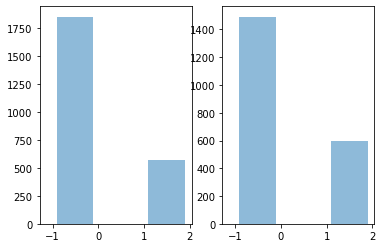

MI = 0.568 ; Feature: CCU - C1 Mean: 0.185 , C2 Mean: -0.194


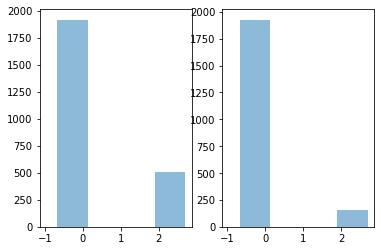

MI = 0.517 ; Feature: HCT_last - C1 Mean: 0.11 , C2 Mean: -0.135


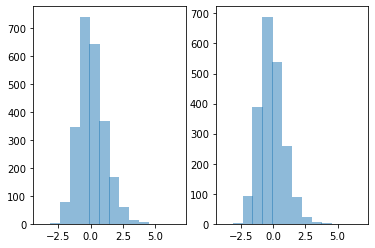

MI = 0.492 ; Feature: MechVentLast8Hour - C1 Mean: 0.324 , C2 Mean: -0.398


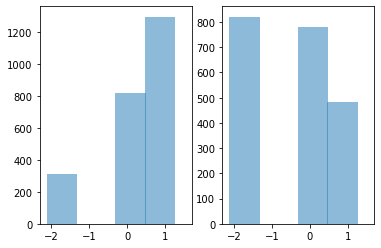

MI = 0.488 ; Feature: CSRU - C1 Mean: -0.333 , C2 Mean: 0.425


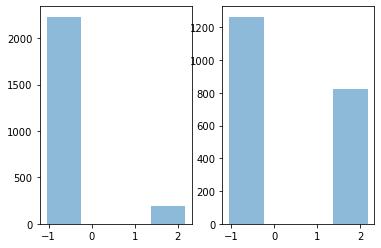

MI = 0.485 ; Feature: PaO2_last - C1 Mean: -0.048 , C2 Mean: -0.031


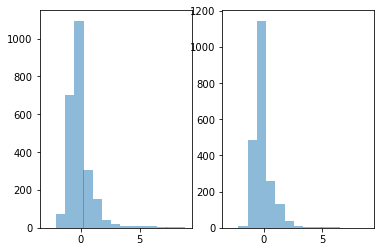

MI = 0.475 ; Feature: HCT_first - C1 Mean: 0.167 , C2 Mean: -0.205


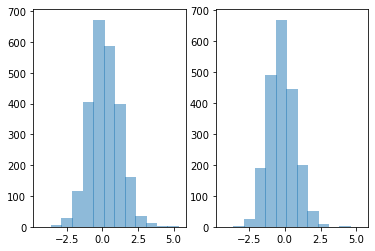

MI = 0.455 ; Feature: NISysABP_first - C1 Mean: 0.139 , C2 Mean: -0.193


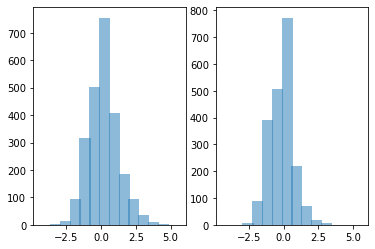

MI = 0.449 ; Feature: NIDiasABP_highest - C1 Mean: 0.164 , C2 Mean: -0.207


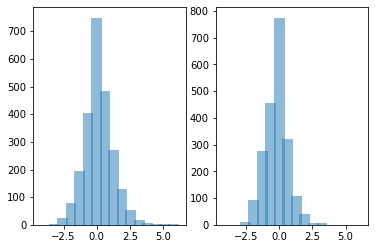

MI = 0.449 ; Feature: Na_first - C1 Mean: -0.067 , C2 Mean: 0.033


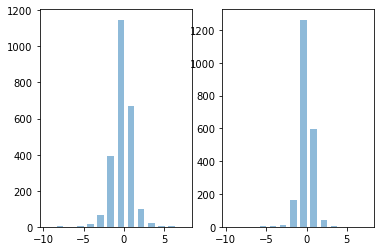



MIFD Analysis of Clusters:  2,0
|C1| =  2238 , |C2| =  2086
MI = 0.77 ; Feature: TroponinI_last - C1 Mean: -0.071 , C2 Mean: -0.054


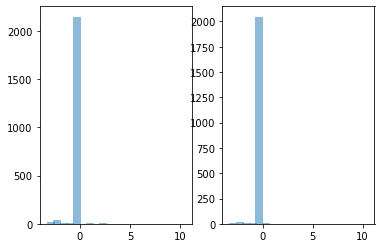

MI = 0.755 ; Feature: TroponinI_first - C1 Mean: -0.06 , C2 Mean: -0.041


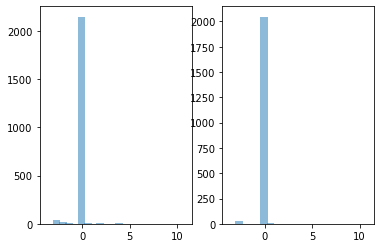

MI = 0.715 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: 0.425


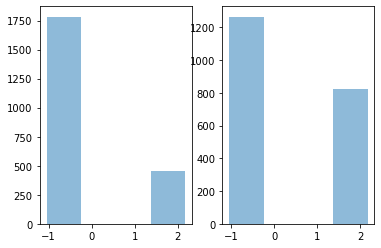

MI = 0.679 ; Feature: SICU - C1 Mean: 0.092 , C2 Mean: 0.012


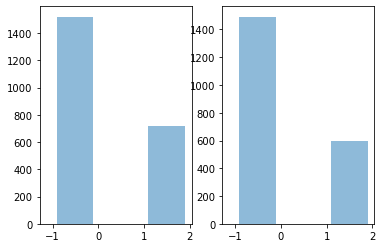

MI = 0.643 ; Feature: CCU - C1 Mean: -0.02 , C2 Mean: -0.194


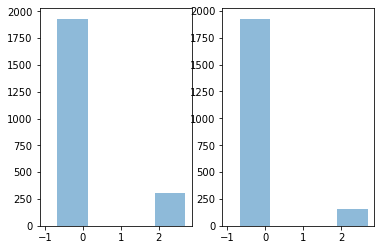

MI = 0.576 ; Feature: K_first - C1 Mean: -0.079 , C2 Mean: -0.091


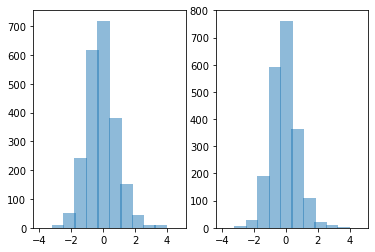

MI = 0.563 ; Feature: HR_first - C1 Mean: -0.016 , C2 Mean: -0.311


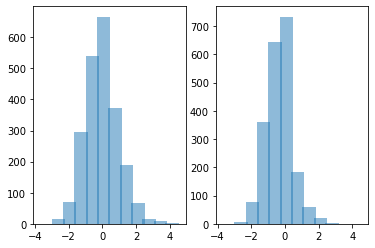

MI = 0.557 ; Feature: Age - C1 Mean: 0.004 , C2 Mean: 0.191


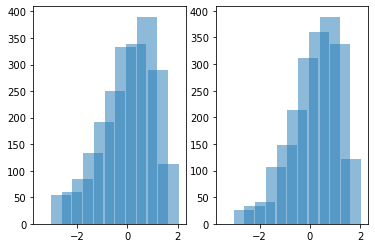

MI = 0.529 ; Feature: SAPS-I - C1 Mean: -0.03 , C2 Mean: -0.147


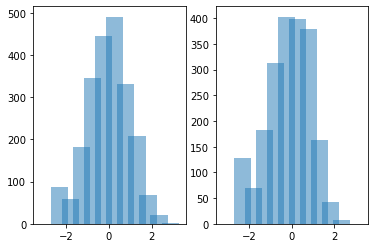

MI = 0.529 ; Feature: NIDiasABP_last - C1 Mean: 0.008 , C2 Mean: -0.07


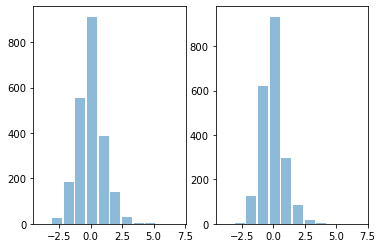



MIFD Analysis of Clusters:  2,1
|C1| =  2238 , |C2| =  2426
MI = 0.917 ; Feature: CCU - C1 Mean: -0.02 , C2 Mean: 0.185


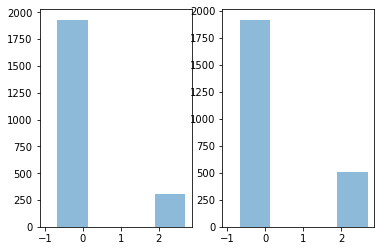

MI = 0.71 ; Feature: SICU - C1 Mean: 0.092 , C2 Mean: -0.095


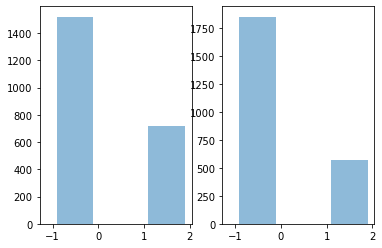

MI = 0.581 ; Feature: TroponinI_first - C1 Mean: -0.06 , C2 Mean: 0.09


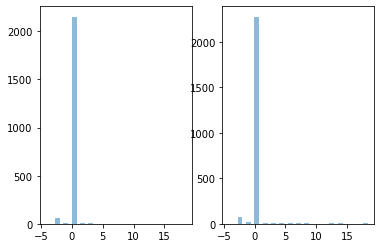

MI = 0.573 ; Feature: NIDiasABP_median - C1 Mean: 0.024 , C2 Mean: 0.17


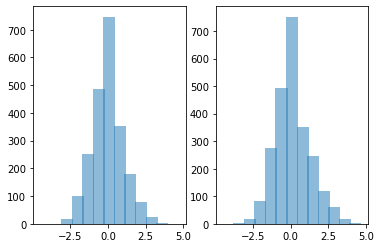

MI = 0.573 ; Feature: NIMAP_median - C1 Mean: 0.028 , C2 Mean: 0.152


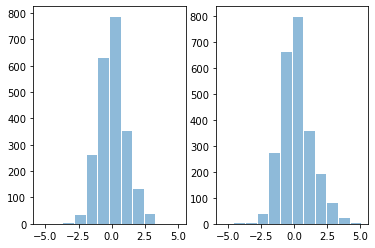

MI = 0.563 ; Feature: NIMAP_first - C1 Mean: 0.028 , C2 Mean: 0.175


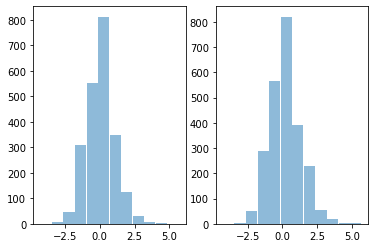

MI = 0.562 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: -0.333


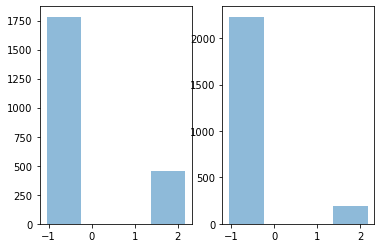

MI = 0.548 ; Feature: SOFA - C1 Mean: -0.061 , C2 Mean: 0.167


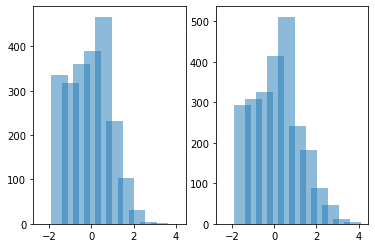

MI = 0.535 ; Feature: DiasABP_last - C1 Mean: -0.023 , C2 Mean: 0.19


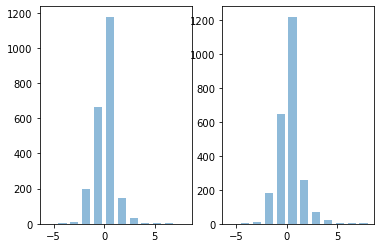

MI = 0.527 ; Feature: NISysABP_highest - C1 Mean: 0.012 , C2 Mean: 0.118


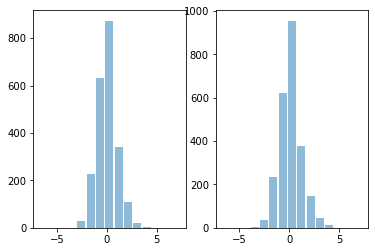

In [132]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c], 0)
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("MIFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C1| = ", len(ci), ", |C2| = ", len(cj))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## HTFD

Hypothesis testing based feature discrimination



1,0
{'SAPS-I': 1.0, 'SOFA': 1.0, 'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0, 'Glucose_first': 1.0}
1.0 SAPS-I - C1: 0.15345951823856196 , C2: -0.14655763751994957


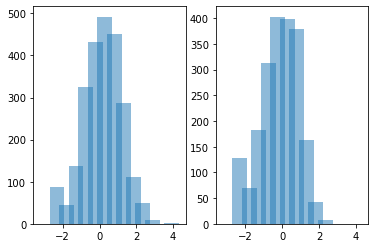

1.0 SOFA - C1: 0.1674780442780594 , C2: -0.12986444922997992


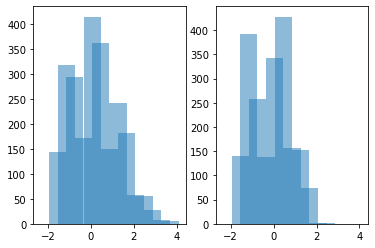

1.0 Length_of_stay - C1: 0.21666239166560722 , C2: -0.23114916940503724


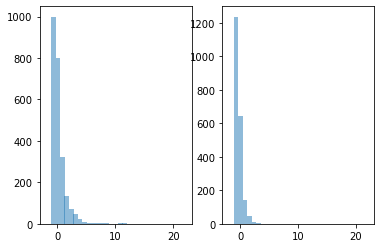

1.0 Age - C1: -0.16809973262997618 , C2: 0.19122668618702704


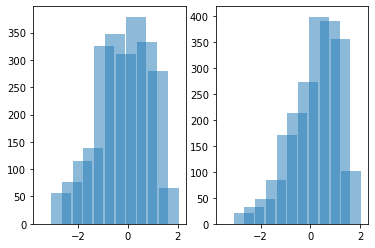

1.0 Weight - C1: 0.20526173426408284 , C2: -0.22095067462244647


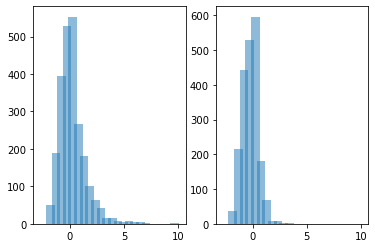

1.0 CCU - C1: 0.1854413519006226 , C2: -0.1944048311536681


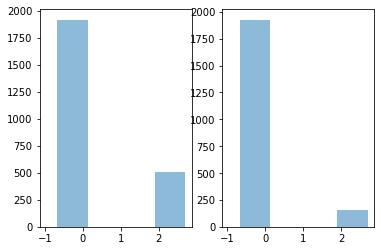

1.0 CSRU - C1: -0.33317452215322463 , C2: 0.4254715179493878


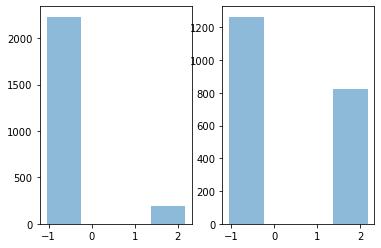

1.0 DiasABP_first - C1: 0.32422241554424125 , C2: -0.30545929687631135


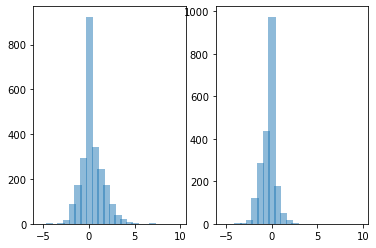

1.0 GCS_first - C1: 0.17701821152004207 , C2: -0.20696105908334356


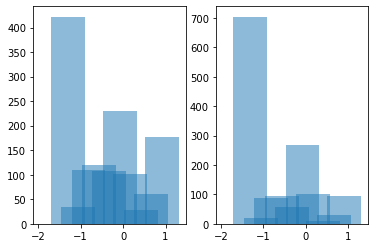

1.0 Glucose_first - C1: 0.3059249429132382 , C2: -0.3062156411010317


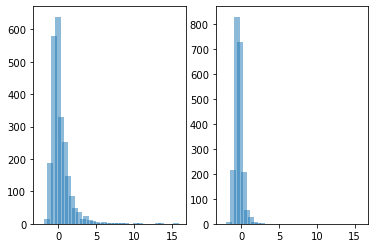



2,0
{'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0, 'Glucose_first': 1.0, 'HR_first': 1.0, 'MAP_first': 1.0}
1.0 Length_of_stay - C1: -0.019412776944528382 , C2: -0.23114916940503724


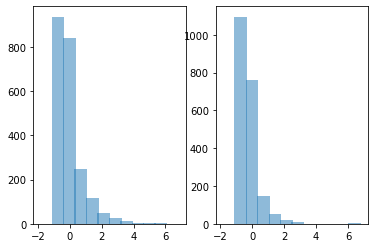

1.0 Age - C1: 0.003981717593468143 , C2: 0.19122668618702704


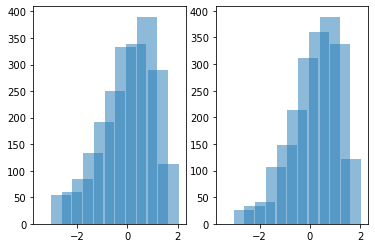

1.0 Weight - C1: -0.016560259187775626 , C2: -0.22095067462244647


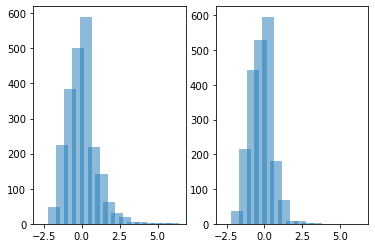

1.0 CCU - C1: -0.01981780246843372 , C2: -0.1944048311536681


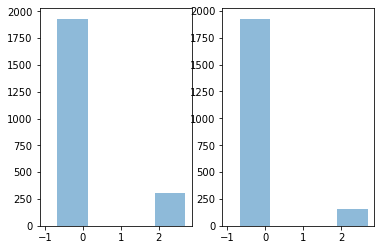

1.0 CSRU - C1: -0.035412062421224466 , C2: 0.4254715179493878


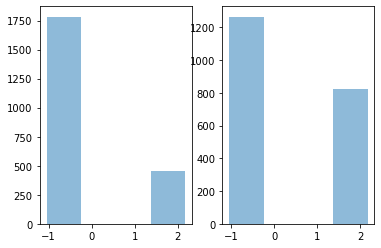

1.0 DiasABP_first - C1: -0.06674507901087752 , C2: -0.30545929687631135


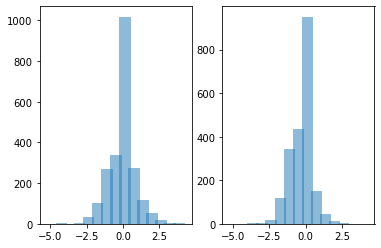

1.0 GCS_first - C1: 0.0010163485702518477 , C2: -0.20696105908334356


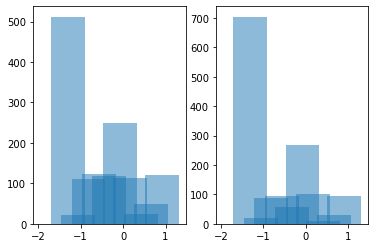

1.0 Glucose_first - C1: -0.04620557827111871 , C2: -0.3062156411010317


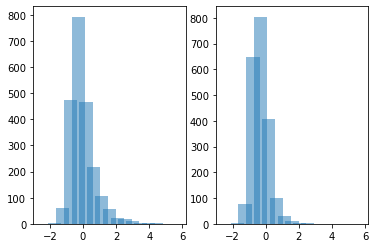

1.0 HR_first - C1: -0.015509233011921022 , C2: -0.31114226114503024


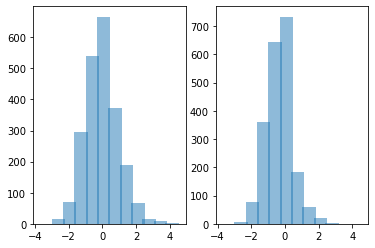

1.0 MAP_first - C1: -0.08318553773522841 , C2: -0.25479285025742826


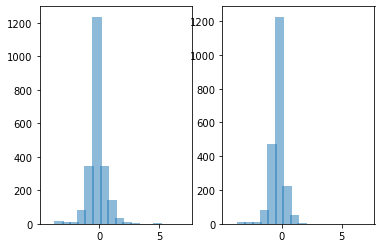



2,1
{'SAPS-I': 1.0, 'SOFA': 1.0, 'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'SICU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0}
1.0 SAPS-I - C1: -0.029746898740006567 , C2: 0.15345951823856196


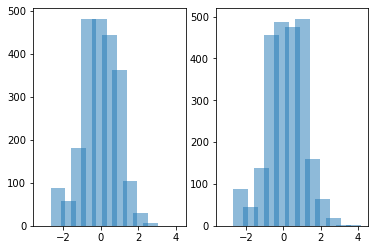

1.0 SOFA - C1: -0.06050245501556481 , C2: 0.1674780442780594


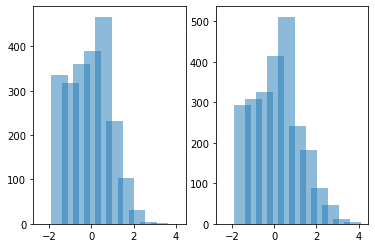

1.0 Length_of_stay - C1: -0.019412776944528382 , C2: 0.21666239166560722


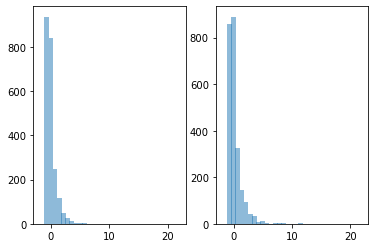

1.0 Age - C1: 0.003981717593468143 , C2: -0.16809973262997618


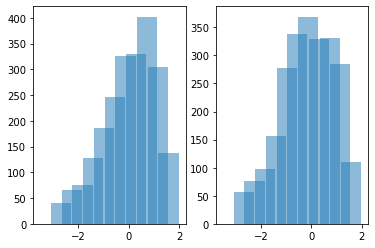

1.0 Weight - C1: -0.016560259187775626 , C2: 0.20526173426408284


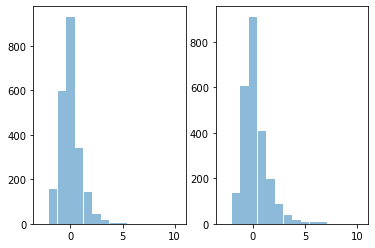

1.0 CCU - C1: -0.01981780246843372 , C2: 0.1854413519006226


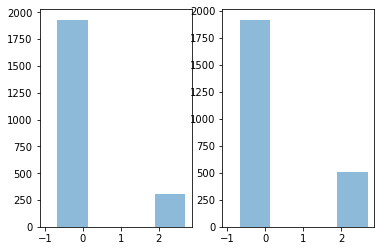

1.0 CSRU - C1: -0.035412062421224466 , C2: -0.33317452215322463


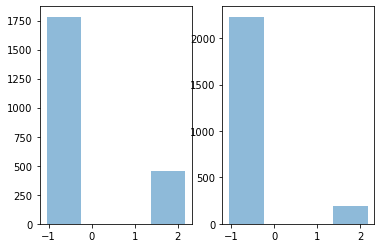

1.0 SICU - C1: 0.0922977777179823 , C2: -0.0953937544911749


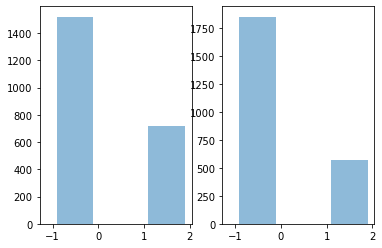

1.0 DiasABP_first - C1: -0.06674507901087752 , C2: 0.32422241554424125


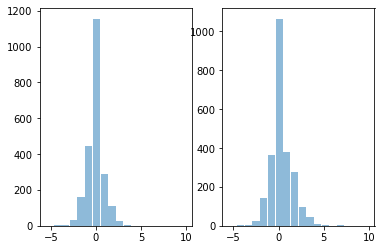

1.0 GCS_first - C1: 0.0010163485702518477 , C2: 0.17701821152004207


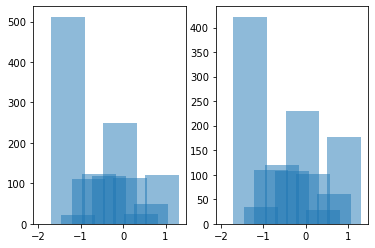

In [134]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi, Xj, axis=0, equal_var=True))[1]
            for c in range(n_columns):
                mi_scores[joint_col_name][c] = np.round(np.exp(-p_vals[c]/0.05), 3)
                # print(column_names[c], ":", c_entropy)
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({column_names[k]: v for k, v in sorted_dict})
            for k, v in sorted_dict:
                print(v, column_names[k], "- C1:", np.mean(scaled_X_train[ci][:,k]), ", C2:", np.mean(scaled_X_train[cj][:,k]))
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## WDFD

Wasserstein Distance based feature discrimination

In [135]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
# scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = wd(Xi[:,c], Xj[:,c])
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("WDFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C{}| = {}, |C{}| = {}".format(i, len(ci), j, len(cj)))
            print("|C{}| = {:.3f}, |C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci), j, sum(y_train[cj])/len(cj)))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                # plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])



WDFD Analysis of Clusters:  1,0
|C1| = 2426, |C0| = 2086
|C1| = 0.569, |C0| = 0.541
MI = 0.82 ; Feature: GCS_last - C1 Mean: -0.399 , C2 Mean: 0.421
MI = 0.778 ; Feature: BUN_last - C1 Mean: 0.421 , C2 Mean: -0.356
MI = 0.759 ; Feature: CSRU - C1 Mean: -0.333 , C2 Mean: 0.425
MI = 0.733 ; Feature: BUN_first - C1 Mean: 0.385 , C2 Mean: -0.348
MI = 0.726 ; Feature: Creatinine_last - C1 Mean: 0.41 , C2 Mean: -0.316
MI = 0.725 ; Feature: Creatinine_first - C1 Mean: 0.4 , C2 Mean: -0.325
MI = 0.722 ; Feature: MechVentLast8Hour - C1 Mean: 0.324 , C2 Mean: -0.398
MI = 0.719 ; Feature: Glucose_highest - C1 Mean: 0.367 , C2 Mean: -0.352
MI = 0.633 ; Feature: DiasABP_first - C1 Mean: 0.324 , C2 Mean: -0.305
MI = 0.632 ; Feature: HR_median - C1 Mean: 0.294 , C2 Mean: -0.338


WDFD Analysis of Clusters:  2,0
|C2| = 2238, |C0| = 2086
|C2| = 0.564, |C0| = 0.541
MI = 0.461 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: 0.425
MI = 0.418 ; Feature: MechVentLast8Hour - C1 Mean: 0.02 , C2 Mean: -0.398
MI